In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
import scipy.sparse as sp
import scipy
import numpy as np
n = 250
ex = np.ones(n);
lp1 = -sp.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
ee = scipy.sparse.eye(n, n)
res_all_nostab = []
res_all_bicg_nostab = []
res_all = []
res_all_bicg = []
res_all_nopc = []
res_all_bicg_nopc = []
lp2 = scipy.sparse.kron(lp1, ee) + scipy.sparse.kron(ee, lp1)
rhs = np.ones(n * n)

def my_print_nopc(r):
    res_all_nopc.append(r)

def my_print2_nopc(x): #For BiCGStab they have another callback, please rewrite
    res_all_bicg_nopc.append(np.linalg.norm(lp2.dot(x) - rhs))

def my_print(r):
    res_all.append(r)

def my_print2(x): #For BiCGStab they have another callback, please rewrite
    res_all_bicg.append(np.linalg.norm(lp2.dot(x) - rhs))

def my_print_nostab(r):
    res_all_nostab.append(r)

def my_print2_nostab(x): #For BiCGStab they have another callback, please rewrite
    res_all_bicg_nostab.append(np.linalg.norm(lp2.dot(x) - rhs))

    
M = scipy.sparse.linalg.spilu(lp2, drop_tol=1e-3)
lo = scipy.sparse.linalg.LinearOperator(lp2.shape, lambda x: M.solve(x))
#Create prec
lo = scipy.sparse.linalg.LinearOperator(lp2.shape, lambda x: M.solve(x))
# sol = scipy.sparse.linalg.gmres(lp2, rhs, callback=my_print, M=lo, restart=50)

# sol2 = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=my_print2, M=lo)

D = scipy.sparse.diags(1 / lp2.diagonal())
sol = scipy.sparse.linalg.gmres(lp2, rhs, callback=my_print, M=D, restart=50)

sol2 = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=my_print2, M=D)

sol_nopc = scipy.sparse.linalg.gmres(lp2, rhs, callback=my_print_nopc, restart=100)
# plt.semilogy(res_all, marker='x',label='GMRES')
sol2_nopc = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=my_print2_nopc)

sol2_nostab = scipy.sparse.linalg.bicg(lp2, rhs, callback=my_print2_nostab)
# plt.xlabel('Iteration number')
# plt.ylabel('Residual')
# plt.semilogy(res_all_bicg, label='BiCGStab', marker='o')
# plt.legend(loc='best')

import scipy.sparse as sp


In [3]:

M = scipy.sparse.linalg.spilu(lp2, drop_tol=1e-3)
lo = scipy.sparse.linalg.LinearOperator(lp2.shape, lambda x: M.solve(x))

In [4]:
D = scipy.sparse.diags(1 / lp2.diagonal())
# D = lo

In [5]:
gmres_prec = []
gmres_no_prec = []

def callback(r):
    gmres_prec.append(r)
sol = scipy.sparse.linalg.gmres(lp2, rhs, callback=callback, M=D, restart=50)

def callback(r):
    gmres_no_prec.append(r)
sol = scipy.sparse.linalg.gmres(lp2, rhs, callback=callback, restart=50)

In [6]:
bicg_no_prec = []
bicg_prec = []

def callback(x):
    bicg_prec.append(np.linalg.norm(lp2.dot(x) - rhs))

sol2_nostab = scipy.sparse.linalg.bicg(lp2, rhs, callback=callback, M=D)
def callback(x):
    bicg_no_prec.append(np.linalg.norm(lp2.dot(x) - rhs))

sol2_nostab = scipy.sparse.linalg.bicg(lp2, rhs, callback=callback)


In [7]:
bicg_stab_no_prec = []
bicg_stab_prec = []

def callback(x):
    bicg_stab_prec.append(np.linalg.norm(lp2.dot(x) - rhs))

sol2_nostab = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=callback, M=D)
def callback(x):
    bicg_stab_no_prec.append(np.linalg.norm(lp2.dot(x) - rhs))

sol2_nostab = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=callback)

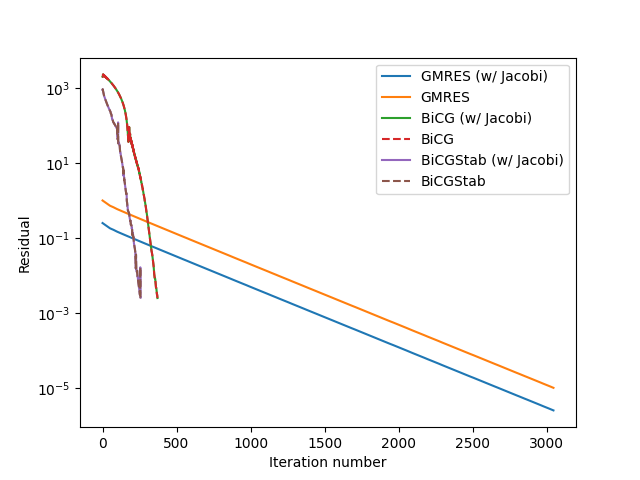

In [8]:


fig, axis = plt.subplots(1,1)

axis.semilogy(gmres_prec, label='GMRES (w/ Jacobi)')
axis.semilogy(gmres_no_prec, label='GMRES')

axis.semilogy(bicg_prec, label='BiCG (w/ Jacobi)')
axis.semilogy(bicg_no_prec, label='BiCG', ls = '--')

axis.semilogy(bicg_stab_prec, label='BiCGStab (w/ Jacobi)')
axis.semilogy(bicg_stab_no_prec, label='BiCGStab', ls = '--')

axis.set_xlabel('Iteration number')
axis.set_ylabel('Residual')

# axis.semilogy(convergence_sp, label='BiCGStab (PyTorch)', marker='o')
axis.legend(loc='best')


In [9]:
import torch
# Convert lp2 to COO format
lp2_coo = lp2.tocoo()

# Get the values and indices
values = lp2_coo.data
row_indices = lp2_coo.row
col_indices = lp2_coo.col

H_sp = torch.tensor(values, dtype = torch.float64)
B_sp = torch.tensor(rhs, dtype = torch.float64)
i_sp = torch.tensor(row_indices, dtype = torch.int64)
j_sp = torch.tensor(col_indices, dtype = torch.int64)
x0_sp = torch.zeros_like(B_sp)

# xk_sp, convergence_sp, num_iter_sp, residual_sp = bicg(H_sp, B_sp, x0_sp, i_sp, j_sp, tol =1e-5, maxIter = 512)


In [10]:
# def make_system(A, M, x0, b):
#     """Make a linear system Ax=b

#     Parameters
#     ----------
#     A : LinearOperator
#         sparse or dense matrix (or any valid input to aslinearoperator)
#     M : {LinearOperator, Nones}
#         preconditioner
#         sparse or dense matrix (or any valid input to aslinearoperator)
#     x0 : {array_like, str, None}
#         initial guess to iterative method.
#         ``x0 = 'Mb'`` means using the nonzero initial guess ``M @ b``.
#         Default is `None`, which means using the zero initial guess.
#     b : array_like
#         right hand side

#     Returns
#     -------
#     (A, M, x, b, postprocess)
#         A : LinearOperator
#             matrix of the linear system
#         M : LinearOperator
#             preconditioner
#         x : rank 1 ndarray
#             initial guess
#         b : rank 1 ndarray
#             right hand side
#         postprocess : function
#             converts the solution vector to the appropriate
#             type and dimensions (e.g. (N,1) matrix)

#     """
#     A_ = A
#     A = aslinearoperator(A)

#     if A.shape[0] != A.shape[1]:
#         raise ValueError(f'expected square matrix, but got shape={(A.shape,)}')

#     N = A.shape[0]

#     b = asanyarray(b)

#     if not (b.shape == (N,1) or b.shape == (N,)):
#         raise ValueError(f'shapes of A {A.shape} and b {b.shape} are '
#                          'incompatible')

#     if b.dtype.char not in 'fdFD':
#         b = b.astype('d')  # upcast non-FP types to double

#     def postprocess(x):
#         return x

#     if hasattr(A,'dtype'):
#         xtype = A.dtype.char
#     else:
#         xtype = A.matvec(b).dtype.char
#     xtype = coerce(xtype, b.dtype.char)

#     b = asarray(b,dtype=xtype)  # make b the same type as x
#     b = b.ravel()

#     # process preconditioner
#     if M is None:
#         if hasattr(A_,'psolve'):
#             psolve = A_.psolve
#         else:
#             psolve = id
#         if hasattr(A_,'rpsolve'):
#             rpsolve = A_.rpsolve
#         else:
#             rpsolve = id
#         if psolve is id and rpsolve is id:
#             M = IdentityOperator(shape=A.shape, dtype=A.dtype)
#         else:
#             M = LinearOperator(A.shape, matvec=psolve, rmatvec=rpsolve,
#                                dtype=A.dtype)
#     else:
#         M = aslinearoperator(M)
#         if A.shape != M.shape:
#             raise ValueError('matrix and preconditioner have different shapes')

#     # set initial guess
#     if x0 is None:
#         x = zeros(N, dtype=xtype)
#     elif isinstance(x0, str):
#         if x0 == 'Mb':  # use nonzero initial guess ``M @ b``
#             bCopy = b.copy()
#             x = M.matvec(bCopy)
#     else:
#         x = array(x0, dtype=xtype)
#         if not (x.shape == (N, 1) or x.shape == (N,)):
#             raise ValueError(f'shapes of A {A.shape} and '
#                              f'x0 {x.shape} are incompatible')
#         x = x.ravel()

#     return A, M, x, b, postprocess

In [11]:
# Convert lp2 to COO format
lp2_coo = lp2.tocoo()

# Get the values and indices
values = lp2_coo.data
row_indices = lp2_coo.row
col_indices = lp2_coo.col

H_sp = torch.tensor(values, dtype = torch.float64)
B_sp = torch.tensor(rhs, dtype = torch.float64)
i_sp = torch.tensor(row_indices, dtype = torch.int64)
j_sp = torch.tensor(col_indices, dtype = torch.int64)
x0_sp = torch.zeros_like(B_sp)

In [12]:
# random_mat = lp2.copy()
# random_mat.data = np.random.rand(random_mat.data.size)
# H_sp = torch.tensor(random_mat.data, dtype = torch.float64)

In [13]:
A_op = scipy.sparse.linalg.aslinearoperator(lp2)
matvec, rmatvec = A_op.matvec, A_op.rmatvec

x0 = np.random.rand(lp2.shape[0])

M_precond = H_sp.new_ones(B_sp.shape[0])
M_i = torch.arange(B_sp.shape[0])
M_j = torch.arange(B_sp.shape[0])


In [14]:
A_coo = (H_sp, (i_sp, j_sp), B_sp.shape[0])
M_coo = (M_precond, (M_i, M_j), B_sp.shape[0])

In [15]:
matvec(x0)

array([-0.5525878 ,  2.53455277, -2.18726438, ..., -1.5366236 ,
        2.02285313, -0.41064178])

In [16]:

from typing import Optional, Tuple
from diffSPH.v2.math import scatter_sum

@torch.jit.script
def matvec_sparse_coo(A: Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], int], x):
    return scatter_sum(A[0] * x[A[1][1]], A[1][0], dim = 0, dim_size = x.shape[0]) 

@torch.jit.script
def rmatvec_sparse_coo(A: Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], int], x):
    return scatter_sum(A[0] * x[A[1][0]], A[1][1], dim = 0, dim_size = x.shape[0]) 

@torch.jit.script
def make_id(A : Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], int]):
    M_precond = A[0].new_ones(A[2])
    M_i = torch.arange(A[2]).to(M_precond.device).to(torch.int64)
    M_j = torch.arange(A[2]).to(M_precond.device).to(torch.int64)

    return (M_precond, (M_i, M_j), A[2])

In [17]:
torch.finfo(x0_sp.dtype).eps

2.220446049250313e-16

In [18]:
torch.zeros_like(B_sp)

tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

In [19]:

@torch.jit.script
def _get_atol_rtol(name:str, b_norm:float, atol:float=0., rtol:float=1e-5):
    """
    A helper function to handle tolerance normalization
    """
    # if atol == 'legacy' or atol is None or atol < 0:
    #     msg = (f"'scipy.sparse.linalg.{name}' called with invalid `atol`={atol}; "
    #            "if set, `atol` must be a real, non-negative number.")
    #     raise ValueError(msg)

    atol = max(float(atol), float(rtol) * float(b_norm))

    return atol, rtol
@torch.jit.script
def _get_tensor_eps(
    x: torch.Tensor,
    eps16: float = torch.finfo(torch.float16).eps,
    eps32: float = torch.finfo(torch.float32).eps,
    eps64: float = torch.finfo(torch.float64).eps,
) -> float:
    if x.dtype == torch.float16:
        return eps16
    elif x.dtype == torch.float32:
        return eps32
    elif x.dtype == torch.float64:
        return eps64
    else:
        raise RuntimeError(f"Expected x to be floating-point, got {x.dtype}")
    
# @torch.jit.script
def bicg(A: Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], int], b, x0:Optional[torch.Tensor]=None, rtol:float=1e-5, atol:float=0., maxiter:Optional[int]=None, M:Optional[Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor],int]]=None, maxIter: int = 512, tol: float = 1e-5):
    # A, M, x, b, postprocess = make_system(A, M, x0, b)
    if M is None:
        M = make_id(A)
    x = x0.clone() if x0 is not None else torch.zeros_like(b)
    bnrm2 = torch.linalg.norm(b)

    atol, _ = _get_atol_rtol('bicg', bnrm2, atol, rtol)

    convergence = []
    
    if bnrm2 == 0:
        print('bnrm2 == 0')
        return b, 0, convergence
        # return postprocess(b), 0

    n = len(b)
    dotprod = torch.dot

    if maxiter is None:
        maxiter = n*10

    # matvec, rmatvec = A.matvec, A.rmatvec
    # psolve, rpsolve = M.matvec, M.rmatvec
    # print(torch.finfo(x.dtype).eps**2)
    rhotol = _get_tensor_eps(x)**2
    # print(rhotol)

    # # Dummy values to initialize vars, silence linter warnings
    # rho_prev, p, ptilde = r.clone(), r.clone(), r.clone()
    rho_prev = torch.zeros_like(b)
    p = torch.zeros_like(b)
    ptilde = torch.zeros_like(b)

    r = b - matvec_sparse_coo(A, x) if x.any() else b.clone()

    # return r, 0 , convergence
    rtilde = r.clone()

    for iteration in range(maxiter):
        rNorm = torch.linalg.norm(r)
        if rNorm < atol:  # Are we done?
            return x, iteration , convergence

        print(f'Iter {iteration}, Residual: {torch.linalg.norm(r)}')

        z = matvec_sparse_coo(M, r)
        ztilde = rmatvec_sparse_coo(M, rtilde)
        # order matters in this dot product
        rho_cur = dotprod(rtilde, z)

        if torch.abs(rho_cur) < rhotol:  # Breakdown case
            return x, -10, convergence

        if iteration > 0:
            beta = rho_cur / rho_prev
            p *= beta
            p += z
            ptilde *= beta.conj()
            ptilde += ztilde
        else:  # First spin
            p = z.clone()
            ptilde = ztilde.clone()

        q = matvec_sparse_coo(A, p)
        qtilde = rmatvec_sparse_coo(A, ptilde)
        rv = dotprod(ptilde, q)

        if rv == 0:
            return x, -11, convergence

        alpha = rho_cur / rv
        x += alpha*p
        r -= alpha*q
        rtilde -= alpha.conj()*qtilde
        rho_prev = rho_cur

        # if callback:
            # callback(x)
        convergence.append(torch.linalg.norm(matvec_sparse_coo(A, x) - b))


    # else:  # for loop exhausted
        # Return incomplete progress
    return x, maxiter, convergence


r, iters, convergence = bicg(A_coo, B_sp, x0_sp, tol =1e-5, maxIter = 512)

print('r: ', r)
print('iters: ', iters)
print('convergence: ', convergence)

Iter 0, Residual: 250.0
Iter 1, Residual: 1968.5019685029526
Iter 2, Residual: 1952.6309170100856
Iter 3, Residual: 1984.190661851937
Iter 4, Residual: 2286.963225492872
Iter 5, Residual: 2204.4713340881335
Iter 6, Residual: 2185.9325089519903
Iter 7, Residual: 2238.421138737004
Iter 8, Residual: 2139.3322247359483
Iter 9, Residual: 2219.5198093821023
Iter 10, Residual: 2106.9466203615807
Iter 11, Residual: 2185.247533502393
Iter 12, Residual: 2078.2665000714856
Iter 13, Residual: 2146.6518464466417
Iter 14, Residual: 2050.1815478922895
Iter 15, Residual: 2107.284404417074
Iter 16, Residual: 2021.7612060915872
Iter 17, Residual: 2068.319250406121
Iter 18, Residual: 1992.785997942688
Iter 19, Residual: 2030.112346360303
Iter 20, Residual: 1963.2740755883974
Iter 21, Residual: 1992.7273480107222
Iter 22, Residual: 1933.3159931585121
Iter 23, Residual: 1956.125979304773
Iter 24, Residual: 1903.015346558131
Iter 25, Residual: 1920.2397737438487
Iter 26, Residual: 1872.4682175755706
Iter 27

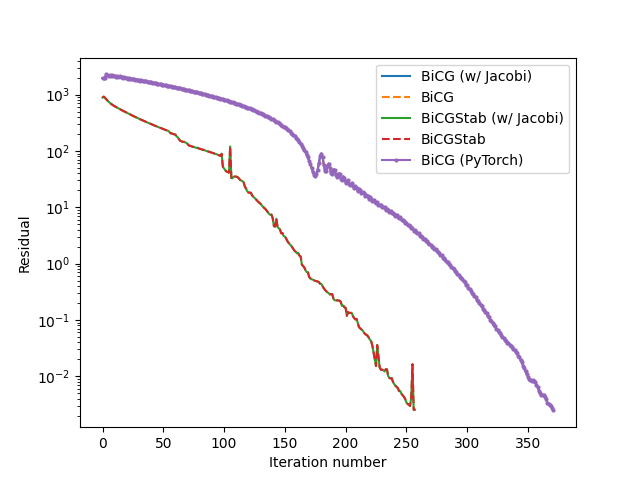

In [20]:


fig, axis = plt.subplots(1,1)

# axis.semilogy(gmres_prec, label='GMRES (w/ Jacobi)')
# axis.semilogy(gmres_no_prec, label='GMRES')

axis.semilogy(bicg_prec, label='BiCG (w/ Jacobi)')
axis.semilogy(bicg_no_prec, label='BiCG', ls = '--')

axis.semilogy(bicg_stab_prec, label='BiCGStab (w/ Jacobi)')
axis.semilogy(bicg_stab_no_prec, label='BiCGStab', ls = '--')

axis.semilogy(convergence, label='BiCG (PyTorch)', marker='o', markersize=2)

axis.set_xlabel('Iteration number')
axis.set_ylabel('Residual')

# axis.semilogy(convergence_sp, label='BiCGStab (PyTorch)', marker='o')
axis.legend(loc='best')


In [93]:
# @torch.jit.script
def bicgstab(A: Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], int], b, x0:Optional[torch.Tensor]=None, tol:float = 1e-5, rtol:float=1e-5, atol:float=0., maxiter:Optional[int]=None, M:Optional[ Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], int]]=None):
    if M is None:
        M = make_id(A)
    x = x0.clone() if x0 is not None else torch.zeros_like(b)

    bnrm2 = torch.linalg.norm(b)

    atol, _ = _get_atol_rtol('bicgstab', bnrm2, atol, rtol)
    convergence = []
    residuals = []

    if bnrm2 == 0:
        return b, 0, convergence

    n = len(b)

    dotprod = torch.dot

    if maxiter is None:
        maxiter = n*10

    # matvec = A.matvec
    # psolve = M.matvec

    # These values make no sense but coming from original Fortran code
    # sqrt might have been meant instead.
    rhotol = _get_tensor_eps(x)**2
    omegatol = rhotol

    # Dummy values to initialize vars, silence linter warnings
    rho_prev = torch.zeros_like(b)
    omega = 0.
    alpha = 0.
    p = torch.zeros_like(b)
    v = torch.zeros_like(b)
    # rho_prev, omega, alpha, p, v = None, None, None, None, None

    r = b -  matvec_sparse_coo(A, x) if x.any() else b.clone()
    rtilde = r.clone()
    residuals.append(matvec_sparse_coo(A, x))

    for iteration in range(maxiter):

        if torch.linalg.norm(r) < atol:  # Are we done?
            return x, iteration, convergence, residuals

        rho = dotprod(rtilde, r)
        if torch.abs(rho) < rhotol:  # rho breakdown
            return x, -10, convergence, residuals

        if iteration > 0:
            if torch.abs(omega) < omegatol:  # omega breakdown
                return x, -11, convergence, residuals

            beta = (rho / rho_prev) * (alpha / omega)
            p -= omega*v
            p *= beta
            p += r
        else:  # First spin
            s = torch.empty_like(r)
            p = r.clone()

        phat = matvec_sparse_coo(M, p)
        v = matvec_sparse_coo(A, phat)
        # print(v)
        rv = dotprod(rtilde, v)
        if rv == 0:
            return x, -11, convergence, residuals
        alpha = rho / rv
        r -= alpha*v
        s[:] = r[:]

        if torch.linalg.norm(s) < atol:
            x += alpha*phat
            return x, 0, convergence, residuals

        shat = matvec_sparse_coo(M, s)
        t = matvec_sparse_coo(A, shat)
        omega = dotprod(t, s) / dotprod(t, t)
        x += alpha*phat
        x += omega*shat
        r -= omega*t
        rho_prev = rho

        # print(omega, alpha)
        residual = matvec_sparse_coo(A, x)
        residuals.append(residual)
        convergence.append(torch.linalg.norm(residual - b))

    # else:  # for loop exhausted
        # Return incomplete progress
    return x, maxiter, convergence, residuals



r, iters, convergence_stab, residuals = bicgstab(A_coo, B_sp, x0_sp, tol =1e-5, maxiter = 512)

print('r: ', r)
print('iters: ', iters)
print('convergence: ', convergence)
print('residuals', [r.shape for r in residuals])

r:  tensor([3.3356, 6.1712, 8.7045,  ..., 8.7045, 6.1712, 3.3356],
       dtype=torch.float64)
iters:  0
convergence:  [tensor(0.1204, device='cuda:0'), tensor(0.1015, device='cuda:0'), tensor(0.1023, device='cuda:0'), tensor(0.1014, device='cuda:0')]
residuals [torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), torch.Size([62500]), to

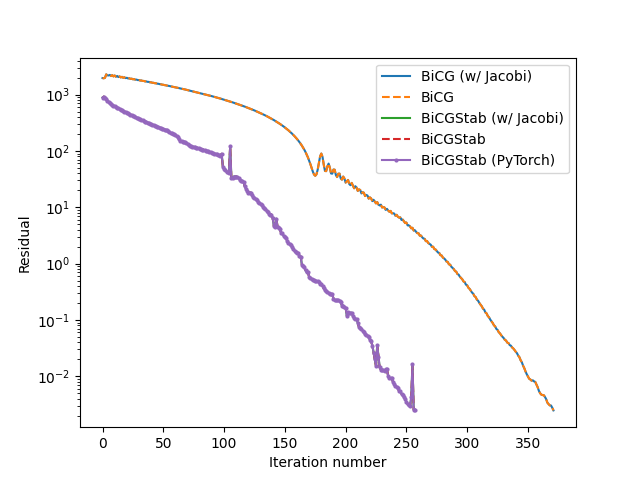

In [22]:


fig, axis = plt.subplots(1,1)

# axis.semilogy(gmres_prec, label='GMRES (w/ Jacobi)')
# axis.semilogy(gmres_no_prec, label='GMRES')

axis.semilogy(bicg_prec, label='BiCG (w/ Jacobi)')
axis.semilogy(bicg_no_prec, label='BiCG', ls = '--')

axis.semilogy(bicg_stab_prec, label='BiCGStab (w/ Jacobi)')
axis.semilogy(bicg_stab_no_prec, label='BiCGStab', ls = '--')

axis.semilogy(convergence_stab, label='BiCGStab (PyTorch)', marker='o', markersize=2)

axis.set_xlabel('Iteration number')
axis.set_ylabel('Residual')

# axis.semilogy(convergence_sp, label='BiCGStab (PyTorch)', marker='o')
axis.legend(loc='best')


In [23]:
H_sp = torch.tensor(values, dtype = torch.float64)
B_sp = torch.tensor(rhs, dtype = torch.float64)
i_sp = torch.tensor(row_indices, dtype = torch.int64)
j_sp = torch.tensor(col_indices, dtype = torch.int64)
x0_sp = torch.zeros_like(B_sp)

r, iters, convergence_stab = bicg(A_coo, B_sp, x0_sp, tol =1e-5, maxIter = 512)

Iter 0, Residual: 250.0
Iter 1, Residual: 1968.5019685029526
Iter 2, Residual: 1952.6309170100856
Iter 3, Residual: 1984.190661851937
Iter 4, Residual: 2286.963225492872
Iter 5, Residual: 2204.4713340881335
Iter 6, Residual: 2185.9325089519903
Iter 7, Residual: 2238.421138737004
Iter 8, Residual: 2139.3322247359483
Iter 9, Residual: 2219.5198093821023
Iter 10, Residual: 2106.9466203615807
Iter 11, Residual: 2185.247533502393
Iter 12, Residual: 2078.2665000714856
Iter 13, Residual: 2146.6518464466417
Iter 14, Residual: 2050.1815478922895
Iter 15, Residual: 2107.284404417074
Iter 16, Residual: 2021.7612060915872
Iter 17, Residual: 2068.319250406121
Iter 18, Residual: 1992.785997942688
Iter 19, Residual: 2030.112346360303
Iter 20, Residual: 1963.2740755883974
Iter 21, Residual: 1992.7273480107222
Iter 22, Residual: 1933.3159931585121
Iter 23, Residual: 1956.125979304773
Iter 24, Residual: 1903.015346558131
Iter 25, Residual: 1920.2397737438487
Iter 26, Residual: 1872.4682175755706
Iter 27

In [24]:
from torch.profiler import profile, record_function, ProfilerActivity
@torch.jit.script
def cg(A: Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], int], b, x0:Optional[torch.Tensor]=None, tol :float = 1e-5, rtol :float =1e-5, atol :float =0., maxiter: Optional[int]=None, M: Optional[Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], int]]=None):
    # with record_function("cg"):
    
    if M is None:
        M = make_id(A)
    x = x0.clone() if x0 is not None else torch.zeros_like(b)
    bnrm2 = torch.linalg.norm(b)

    atol, _ = _get_atol_rtol('cg', bnrm2, atol, rtol)

    convergence = []

    if bnrm2 == 0:
        return b, 0, convergence

    n = len(b)

    if maxiter is None:
        maxiter = n*10

    dotprod = torch.dot

    # matvec = A.matvec
    # psolve = M.matvec
    r = b - matvec_sparse_coo(A, x) if x.any() else b.clone()

    # Dummy value to initialize var, silences warnings
    rho_prev = torch.zeros_like(b)
    p = torch.zeros_like(b)

    for iteration in range(maxiter):
        if torch.linalg.norm(r) < atol:  # Are we done?
            return x, iteration, convergence
        # with record_function("cg_iter"):
        z = matvec_sparse_coo(M, r)
        rho_cur = torch.dot(r, z)
        if iteration > 0:
            beta = rho_cur / rho_prev
            p *= beta
            p += z
        else:  # First spin
            p = z.clone()
            # p = torch.empty_like(r)
            # p[:] = z[:]

        q = matvec_sparse_coo(A, p)
        alpha = rho_cur / torch.dot(p, q)
        x += alpha*p
        r -= alpha*q
        rho_prev = rho_cur

        # if callback:
            # callback(x)
        convergence.append(torch.linalg.norm(matvec_sparse_coo(A, x) - b))

    # else:  # for loop exhausted
        # Return incomplete progress
    return x, maxiter, convergence

In [25]:

with torch.autograd.profiler.profile() as prof:
    r, iters, convergence_cg = cg(A_coo, B_sp, x0_sp, tol =1e-5, maxiter = 512, M = M_coo)

# r, iters, convergence_cg = cg(A_coo, B_sp, x0_sp, tol =1e-5, maxiter = 512, M = M_coo)

# print(prof.)

STAGE:2024-07-09 09:54:17 77044:77044 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-07-09 09:54:19 77044:77044 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-07-09 09:54:19 77044:77044 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [26]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=10))


-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  aten::index        37.03%     766.187ms        37.19%     769.378ms     689.407us          1116  
           aten::scatter_add_        31.81%     658.211ms        31.81%     658.211ms     589.795us          1116  
                    aten::mul        14.75%     305.058ms        14.75%     305.058ms     164.010us          1860  
                           cg         6.23%     128.809ms       100.00%        2.069s        2.069s             1  
                    aten::dot         1.82%      37.656ms         1.86%      38.488ms      51.731us           744  
                    aten::sub         1.56%      32.254ms         1.56% 

In [27]:

r, iters, convergence_cg = cg(A_coo, B_sp, x0_sp, tol =1e-5, maxiter = 512, M = M_coo)

print('r: ', r)
print('iters: ', iters)
print('convergence: ', convergence)

r:  tensor([3.3356, 6.1713, 8.7046,  ..., 8.7046, 6.1713, 3.3356],
       dtype=torch.float64)
iters:  372
convergence:  [tensor(1968.5020, dtype=torch.float64), tensor(1952.6309, dtype=torch.float64), tensor(1984.1907, dtype=torch.float64), tensor(2286.9632, dtype=torch.float64), tensor(2204.4713, dtype=torch.float64), tensor(2185.9325, dtype=torch.float64), tensor(2238.4211, dtype=torch.float64), tensor(2139.3322, dtype=torch.float64), tensor(2219.5198, dtype=torch.float64), tensor(2106.9466, dtype=torch.float64), tensor(2185.2475, dtype=torch.float64), tensor(2078.2665, dtype=torch.float64), tensor(2146.6518, dtype=torch.float64), tensor(2050.1815, dtype=torch.float64), tensor(2107.2844, dtype=torch.float64), tensor(2021.7612, dtype=torch.float64), tensor(2068.3193, dtype=torch.float64), tensor(1992.7860, dtype=torch.float64), tensor(2030.1123, dtype=torch.float64), tensor(1963.2741, dtype=torch.float64), tensor(1992.7273, dtype=torch.float64), tensor(1933.3160, dtype=torch.float64)

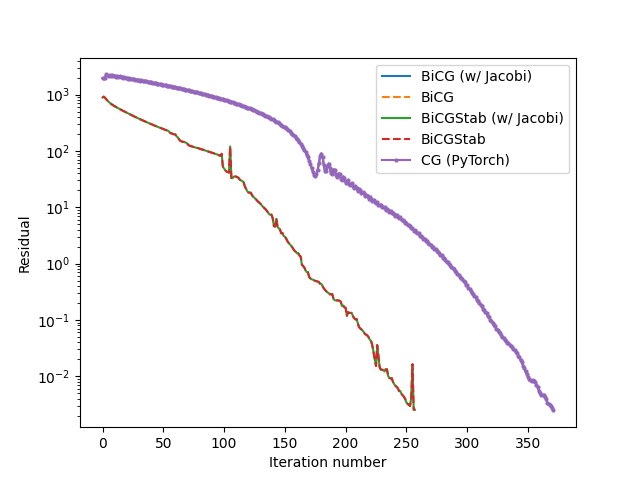

In [28]:


fig, axis = plt.subplots(1,1)

# axis.semilogy(gmres_prec, label='GMRES (w/ Jacobi)')
# axis.semilogy(gmres_no_prec, label='GMRES')

axis.semilogy(bicg_prec, label='BiCG (w/ Jacobi)')
axis.semilogy(bicg_no_prec, label='BiCG', ls = '--')

axis.semilogy(bicg_stab_prec, label='BiCGStab (w/ Jacobi)')
axis.semilogy(bicg_stab_no_prec, label='BiCGStab', ls = '--')

axis.semilogy(convergence_cg, label='CG (PyTorch)', marker='o', markersize=2)

axis.set_xlabel('Iteration number')
axis.set_ylabel('Residual')

# axis.semilogy(convergence_sp, label='BiCGStab (PyTorch)', marker='o')
axis.legend(loc='best')


In [29]:
@torch.jit.script
def BiCG(H, B, x0, i, j, tol : float =1e-5, maxIter : int = 32):
    with record_function("[Shifting] - BiCG Solver"):
        xk = x0
        rk = torch.zeros_like(x0)
        numParticles = rk.shape[0] 

        rk  += scatter_sum(H * xk[j], i, dim=0, dim_size=numParticles)
        
        rk = B - rk
        r0 = rk.clone()
        pk = rk.clone()
        
        num_iter = 0
        convergence = []
        rk_norm = torch.linalg.norm(rk)
        while (torch.abs(torch.linalg.norm(rk) / rk_norm - 1) > 1e-4 or num_iter == 0) and num_iter < maxIter and torch.linalg.norm(rk) > tol:
            rk_norm = torch.linalg.norm(rk)
            apk = torch.zeros_like(x0)

            apk+= scatter_sum(H * pk[j], i, dim=0, dim_size=numParticles)

            alpha = torch.dot(rk, r0) / torch.dot(apk, r0)
            xk = xk + alpha * pk
            rk = rk - alpha * apk

            beta = torch.dot(rk, r0) / torch.dot(r0, r0)
            pk = rk + beta * pk
            
            num_iter += 1
            convergence.append(torch.linalg.norm(rk))

        return xk, convergence, num_iter, torch.linalg.norm(rk)


In [30]:
def BiCGStab_wJacobi(H, B, x0, i, j, tol : float =1e-5, maxIter : int = 32):
    with record_function("[Shifting] - BiCGStab Solver w/ Jacobi Preconditioner"):
        xk = x0
        rk = torch.zeros_like(x0)
        numParticles = rk.shape[0]
        ii = torch.unique(i)
        # Calculate the Jacobi preconditioner
        diag = H[i == j]

        # diag = torch.vstack((H[i == j, 0, 0], H[i == j, 1, 1])).flatten()
        # diag[diag < 1e-8] = 1
        M_inv = 1 / diag
        M_inv[diag < 1e-8] = 0
        # M_inv[torch.isnan(M_inv)] = 1

        rk = scatter_sum(H * xk[j], i, dim=0, dim_size=numParticles)
        rk = B - rk
        r0 = rk.clone()

        # Apply the preconditioner
        # zk = torch.bmm(M_inv, rk.unsqueeze(-1)).squeeze(-1)
        # print(f'i: {i.shape} x j: {j.shape} -> {i[i==j]}, {i}, {j}')
        # print(f'rk: {rk}, M_inv: {M_inv}, @ {M_inv.shape} * {rk.shape}')
        zk = M_inv * rk
        pk = zk.clone()
        
        num_iter = 0
        convergence = []
        rk_norm = torch.linalg.norm(rk)
        while (torch.abs(torch.linalg.norm(rk) / rk_norm - 1) > 1e-3 or num_iter == 0) and num_iter < maxIter and torch.linalg.norm(rk) > tol:
            rk_norm = torch.linalg.norm(rk)
            apk = torch.zeros_like(x0)

            apk  = scatter_sum(H * pk[j], i, dim=0, dim_size=numParticles)

            alpha = torch.dot(rk, r0) / (torch.dot(apk, r0) + 1e-8)
            sk = rk - alpha * apk
            ask = torch.zeros_like(x0)

            ask = scatter_sum(H * sk[j], i, dim=0, dim_size=numParticles)

            omega = torch.dot(ask, sk) / (torch.dot(ask, ask) + 1e-8)
            # print(f'xk: {torch.linalg.norm(xk)}, pk: {torch.linalg.norm(rk)}, sk: {torch.linalg.norm(pk)}')
            # print(f'alpha * pk: {torch.linalg.norm(alpha * pk)}, omega * sk: {torch.linalg.norm(omega * sk)}')

            xk = xk + alpha * pk + omega * sk
            rk = sk - omega * ask

            # Apply the preconditioner
            zk = M_inv * rk
            beta = (torch.dot(rk, r0) / (torch.dot(r0, r0)) + 1e-8) * (alpha / (omega + 1e-8))
            pk = zk + beta * (pk - omega * apk)
            if torch.abs(alpha) < 1e-8 or torch.abs(omega) < 1e-8 or torch.abs(beta) < 1e-8:
                break

            # print('###############################################################################')
            # print(f'Iter: {num_iter}, Residual: {torch.linalg.norm(rk)}, Threshold {tol}')
            # print(f'alpha: {alpha}, omega: {omega}, beta: {beta}')
            # print(f'rk: {rk}, pk: {pk}, xk: {xk}')
            print(f'rk: {torch.linalg.norm(rk)}, xk: {torch.linalg.norm(xk)}, pk: {torch.linalg.norm(pk)}')
            # print(f'apk: {apk}, ask: {ask}')
            # print(torch.dot(rk, r0))
            # print(torch.dot(r0, r0))
            # print((alpha / omega))

            num_iter += 1
            convergence.append(torch.linalg.norm(rk))

        return xk, convergence, num_iter, torch.linalg.norm(rk)



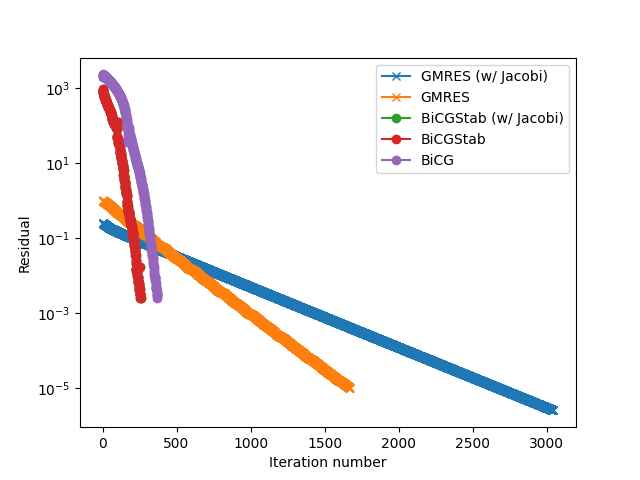

In [31]:
import scipy as sp
import scipy
n = 250
ex = np.ones(n);
lp1 = -sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
ee = scipy.sparse.eye(n, n)
res_all_nostab = []
res_all_bicg_nostab = []
res_all = []
res_all_bicg = []
res_all_nopc = []
res_all_bicg_nopc = []
lp2 = scipy.sparse.kron(lp1, ee) + scipy.sparse.kron(ee, lp1)
rhs = np.ones(n * n)

def my_print_nopc(r):
    res_all_nopc.append(r)

def my_print2_nopc(x): #For BiCGStab they have another callback, please rewrite
    res_all_bicg_nopc.append(np.linalg.norm(lp2.dot(x) - rhs))

def my_print(r):
    res_all.append(r)

def my_print2(x): #For BiCGStab they have another callback, please rewrite
    res_all_bicg.append(np.linalg.norm(lp2.dot(x) - rhs))

def my_print_nostab(r):
    res_all_nostab.append(r)

def my_print2_nostab(x): #For BiCGStab they have another callback, please rewrite
    res_all_bicg_nostab.append(np.linalg.norm(lp2.dot(x) - rhs))

    
# M = scipy.sparse.linalg.spilu(lp2, drop_tol=1e-3)
#Create prec
# lo = scipy.sparse.linalg.LinearOperator(lp2.shape, lambda x: M.solve(x))
# sol = scipy.sparse.linalg.gmres(lp2, rhs, callback=my_print, M=lo, restart=50)

# sol2 = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=my_print2, M=lo)

D = scipy.sparse.diags(1 / lp2.diagonal())
sol = scipy.sparse.linalg.gmres(lp2, rhs, callback=my_print, M=D, restart=50)

sol2 = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=my_print2, M=D)

sol_nopc = scipy.sparse.linalg.gmres(lp2, rhs, callback=my_print_nopc, restart=100)
# plt.semilogy(res_all, marker='x',label='GMRES')
sol2_nopc = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=my_print2_nopc)

sol2_nostab = scipy.sparse.linalg.bicg(lp2, rhs, callback=my_print2_nostab)
# plt.xlabel('Iteration number')
# plt.ylabel('Residual')
# plt.semilogy(res_all_bicg, label='BiCGStab', marker='o')
# plt.legend(loc='best')

import scipy.sparse as sp

# Convert lp2 to COO format
lp2_coo = lp2.tocoo()

# Get the values and indices
values = lp2_coo.data
row_indices = lp2_coo.row
col_indices = lp2_coo.col

H_sp = torch.tensor(values, dtype = torch.float64)
B_sp = torch.tensor(rhs, dtype = torch.float64)
i_sp = torch.tensor(row_indices, dtype = torch.int64)
j_sp = torch.tensor(col_indices, dtype = torch.int64)
x0_sp = torch.zeros_like(B_sp)

# xk_sp, convergence_sp, num_iter_sp, residual_sp = bicg(H_sp, B_sp, x0_sp, i_sp, j_sp, tol =1e-5, maxIter = 512)

fig, axis = plt.subplots(1,1)

axis.semilogy(res_all, marker='x',label='GMRES (w/ Jacobi)')
axis.semilogy(res_all_nopc, marker='x',label='GMRES')
axis.set_xlabel('Iteration number')
axis.set_ylabel('Residual')
axis.semilogy(res_all_bicg, label='BiCGStab (w/ Jacobi)', marker='o')
axis.semilogy(res_all_bicg_nopc, label='BiCGStab', marker='o')
axis.semilogy(res_all_bicg_nostab, label='BiCG', marker='o')

# axis.semilogy(convergence_sp, label='BiCGStab (PyTorch)', marker='o')
axis.legend(loc='best')

In [32]:

sol2 = scipy.sparse.linalg.bicg(lp2, rhs, callback=my_print2, M=D)
# print(D.shape)

In [33]:

sol_nopc = scipy.sparse.linalg.gmres(lp2, rhs, callback=my_print, restart=100)
# plt.semilogy(res_all, marker='x',label='GMRES')
sol2_nopc = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=my_print2)
# plt.xlabel('Iteration number')

In [34]:
print(values.shape, row_indices.shape, col_indices.shape)
print(lp2.shape)

(311500,) (311500,) (311500,)
(62500, 62500)


In [35]:
# H_sp = torch.tensor(values, dtype = torch.float64)
# B_sp = torch.tensor(rhs, dtype = torch.float64)
# i_sp = torch.tensor(row_indices, dtype = torch.int64)
# j_sp = torch.tensor(col_indices, dtype = torch.int64)
# x0_sp = torch.zeros_like(B_sp)

# xk_sp, convergence_sp, num_iter_sp, residual_sp = bicg(H_sp, B_sp, x0_sp, i_sp, j_sp, tol =1e-5, maxIter = 512)

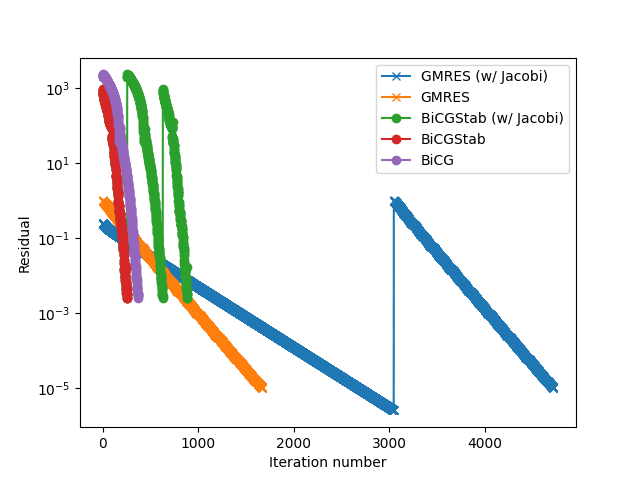

In [36]:
fig, axis = plt.subplots(1,1)

axis.semilogy(res_all, marker='x',label='GMRES (w/ Jacobi)')
axis.semilogy(res_all_nopc, marker='x',label='GMRES')
axis.set_xlabel('Iteration number')
axis.set_ylabel('Residual')
axis.semilogy(res_all_bicg, label='BiCGStab (w/ Jacobi)', marker='o')
axis.semilogy(res_all_bicg_nopc, label='BiCGStab', marker='o')
axis.semilogy(res_all_bicg_nostab, label='BiCG', marker='o')

# axis.semilogy(convergence_sp, label='BiCGStab (PyTorch)', marker='o')
axis.legend(loc='best')

In [37]:
configurationFile = './configurations/01_tgv.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [432]:
nx = 128
L = 1
u_mag = 2
k = 1 * np.pi
TGV_override = False
targetRe = 2000

config['domain']['minExtent'] = -L
config['domain']['maxExtent'] =  L
config['simulation'] = {'correctArea': True}

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cuda'}
config['plot']['export'] = True
config['kernel'] = {'name': 'Wendland4'}
# config['kernel']['targetNeighbors'] = 100
# config['compute'] = {'device': 'cpu'}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)
config['integration']['scheme'] = 'symplecticEuler'
config['integration']['scheme'] = 'semiImplicitEuler'

# print(config['kernel'])

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


$\alpha = 0.009433431170699188$ is very low, consider increasing the value (should be > 0.01)
Re = 2000.0, $\nu_{sph} = 0.002$, $\alpha = 0.009433431170699188$


In [433]:

from torch.profiler import profile, record_function, ProfilerActivity
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.plotting import plotRegions
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

inner = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([1 + config['particle']['dx'] * boundary_width,1 + config['particle']['dx'] * boundary_width]).to(points.device))
outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
boundary_sdf = operatorDict['invert'](inner)


fluid_sdf = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
# fluid_sdf = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/2, - 1/2]))


regions = [
{
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

config['regions'] = regions


In [434]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

# particleState, mask = sampleParticles(config, sdfs = [])
particleState, mask = sampleNoisyParticles(config['noise'], config, sdfs = regions, randomizeParticles = False)

priorState = None
particleState['velocities'][:,0] =  u_mag * torch.cos(k * particleState['positions'][:,0]) * torch.sin(k * particleState['positions'][:,1])
particleState['velocities'][:,1] = -u_mag * torch.sin(k * particleState['positions'][:,0]) * torch.cos(k * particleState['positions'][:,1])

# u_max = torch.linalg.norm(particleState['velocities'], dim = 1).max()
# particleState['velocities'] = particleState['velocities'] / (u_max + 1e-7) * u_mag
Ek0 = 0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(particleState['velocities'], dim = -1)**2

initialVelocities = particleState['velocities'].clone()

particleState['Eks'] =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2)
particleState['E_k'] = particleState['Eks'].sum().cpu().detach().item()


In [435]:
from diffSPH.v2.simulationSchemes.dfsph import simulationStep
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.neighborhood import searchNeighbors

from diffSPH.v2.sampling import generateInitialConditions

# initialState = generateInitialConditions(particleState, config)
initialState = {
    'fluid': particleState,
    'time': 0.0,
    'timestep': 0,
    'dt': torch.tensor(5e-4, device = config['compute']['device']),
}

initialState['fluid']['velocities'][:,0] =  u_mag * torch.cos(k * initialState['fluid']['positions'][:,0]) * torch.sin(k * initialState['fluid']['positions'][:,1])
initialState['fluid']['velocities'][:,1] = -u_mag * torch.sin(k * initialState['fluid']['positions'][:,0]) * torch.cos(k * initialState['fluid']['positions'][:,1])


perennialState = copy.deepcopy(initialState)
config['dfsph']['maxIters'] = 512
config['dfsph']['errorThreshold'] = 5e-4
config['dfsph']['omega'] = 0.33

config['timestep']['dt'] = 1e-3
perennialState['dt'] = 1e-3

priorState = None
perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
perennialState['time'] += perennialState['dt']

searchNeighbors(perennialState, config)
div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)

In [436]:
from diffSPH.v2.simulationSchemes.dfsph import callModule, computeDensity, computeGravity, computeViscosity, sphOperationStates, scatter_sum
solverState = copy.deepcopy(initialState)


In [437]:

solverState['fluid']['velocities'][:,0] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10
solverState['fluid']['velocities'][:,1] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10

In [438]:
searchNeighbors(solverState, config)
solverState['dt'] = 0.01
config['timestep']['dt'] = 0.01

solverState['fluid']['densities'], _ = callModule(solverState, computeDensity, config, 'fluid')
solverState['fluid']['gravityAccel'] = computeGravity(solverState['fluid'], config)
solverState['fluid']['velocityDiffusion'], _ = callModule(solverState, computeViscosity, config, 'fluid')

In [439]:
# solverState['fluid']['advection'] = torch.zeros_like(solverState['fluid']['gravityAccel'])

solverState['fluid']['advection'] = solverState['fluid']['gravityAccel'] + solverState['fluid']['velocityDiffusion']
solverState['fluid']['advectionVelocities'] = solverState['fluid']['velocities'] + solverState['fluid']['advection'] * solverState['dt']

In [440]:
def computeAdvectionDivergence(stateA, stateB, neighborhood, simConfig):
    with record_function("[SPH] - Fluid Divergence ($nabla cdot \\bar{v}$)"):
        divergence = sphOperationStates(stateA, stateB, (stateA['advectionVelocities'], stateB['advectionVelocities']), neighborhood=neighborhood, operation='divergence')
        return divergence
    

solverState['fluid']['velocityDivergence'] = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)
solverState['fluid']['advectionDivergence'] = computeAdvectionDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)


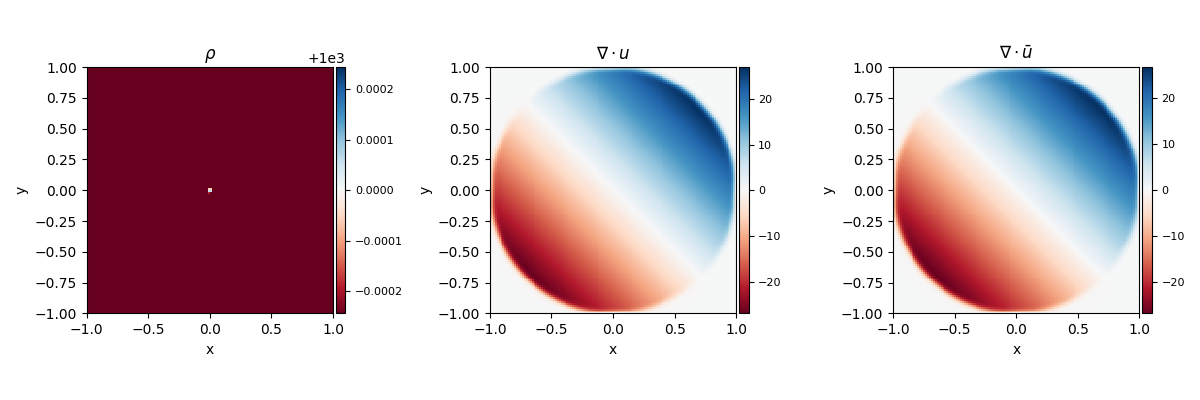

In [441]:
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
from diffSPH.v2.plotting import exportPlot, postProcessPlot
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(solverState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

# xVelPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
#                                       'velocities',
#                                       mapping = '.x', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = 'x-Velocity', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
# yVelPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
#                                       'velocities',
#                                       mapping = '.y', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = 'y-Velocity', plotBoth = False, which = 'fluid', midPoint = 0)

# velPlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
#                                       'velocities',
#                                       mapping = 'L2', s = s, 
#                           scaling = 'lin', gridVisualization=True, cmap = 'viridis', streamLines = True, operation = None, title = '|Velocity|', plotBoth = False, which = 'fluid', midPoint = 0)

# xVelPlot = visualizeParticleQuantity(fig, axis[1,0], config, visualizationState, quantity =
#                                       'advectionVelocities',
#                                       mapping = '.x', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = 'x-Advection', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
# yVelPlot = visualizeParticleQuantity(fig, axis[1,1], config, visualizationState, quantity = 
#                                       'advectionVelocities',
#                                       mapping = '.y', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = 'y-Advection', plotBoth = False, which = 'fluid', midPoint = 0)

# velPlot = visualizeParticleQuantity(fig, axis[1,2], config, visualizationState, quantity = 
#                                       'advectionVelocities',
#                                       mapping = 'L2', s = s, 
#                           scaling = 'lin', gridVisualization=True, cmap = 'viridis', streamLines = True, operation = None, title = '|Advection|', plotBoth = False, which = 'fluid', midPoint = 0)

xVelPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'densities',
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = '$\\rho$', which = 'fluid', plotBoth = False, midPoint = 1000, streamLines = False)
yVelPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'velocityDivergence',
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot u$', plotBoth = False, which = 'fluid', midPoint = 0)

velPlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      'advectionDivergence',
                                      mapping = 'L2', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot \\bar u$', plotBoth = False, which = 'fluid', midPoint = 0)



fig.tight_layout()

# simulationState['fluid']['actualArea'] = simulationState['fluid']['masses'] / simulationState['fluid']['densities']
# 



In [442]:
# def solveISPH(stateA, stateB, config, neighborhood):
#     # stateA = solverState['fluid']
#     # stateB = solverState['fluid']
#     # neighborhood = stateA['neighborhood']

#     i,j = neighborhood['indices']
#     rij = neighborhood['distances']
#     hij = neighborhood['supports']
#     xij = neighborhood['vectors']
#     gradKernels = neighborhood['gradients']
#     pA = stateA['pressures']
#     pB = stateB['pressures']

#     quotient = (rij * hij + 1e-7 * hij)
#     kernelApproximation = torch.linalg.norm(gradKernels, dim = -1) /  quotient
#     kernelApproximation = torch.einsum('nd, nd -> n', gradKernels, -xij)/  quotient# * rij * hij

#     Aij = pA[i] - pB[j]
#     massTerm = stateA['masses'][j] / (stateA['densities'][i] + stateB['densities'][j])
#     dimTerm = config['domain']['dim'] * 2 + 2

#     laplacianTerm = dimTerm * massTerm * kernelApproximation

#     aii = scatter_sum(laplacianTerm, i, dim = 0, dim_size = stateA['positions'].shape[0])

#     mask = i == j

#     A = laplacianTerm
#     A[mask] = aii

#     B = -solverState['fluid']['advectionDivergence'] / solverState['dt']

#     A = (laplacianTerm, (i,j), stateA['numParticles'])

#     p, iters, convergence1 = bicgstab(A, B, torch.zeros_like(B), rtol = 1e-10, tol = 1e-8, maxiter = 512)
#     # p, iters, convergence2 = bicg(A, B, p, rtol = 1e-10, tol = 1e-8, maxiter = 512)
#     # p, iters, convergence3 = bicg(A, B, p, rtol = 1e-10, tol = 1e-8, maxiter = 512)
#     # p, iters, convergence4 = bicg(A, B, p, rtol = 1e-10, tol = 1e-8, maxiter = 512)
#     # p, iters, convergence5 = bicg(A, B, p, rtol = 1e-10, tol = 1e-8, maxiter = 512)

#     return p, iters, convergence1 #+ convergence2# + convergence3 + convergence4 + convergence5

In [443]:
# p, iters, convergence, residuals = solveISPH(solverState['fluid'], solverState['fluid'], config, solverState['fluid']['neighborhood'])

In [445]:
# fig,axis = plt.subplots(1,1)

# axis.semilogy([c.detach().cpu().numpy() for c in convergence], marker='o')

In [446]:
# from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
# from diffSPH.v2.plotting import exportPlot, postProcessPlot

# from diffSPH.v2.simulationSchemes.dfsph import callModule, computeDensity, computeGravity, computeViscosity, sphOperationStates, scatter_sum
# solverState = copy.deepcopy(initialState)

# # solverState['fluid']['velocities'][:,0] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10
# # solverState['fluid']['velocities'][:,1] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10
# solverState['fluid']['velocityDivergence'] = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)

# searchNeighbors(solverState, config)
# solverState['dt'] = 0.01
# config['timestep']['dt'] = 0.01

# fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)


# visualizationState = prepVisualizationState(solverState, config, grid = True)
# # plotRegions(regions, axis[0,0])
# # plotRegions(regions, axis[0,1])

# s = 0.25

# xVelPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
#                                       'densities',
#                                       mapping = '.x', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = '$p$', which = 'fluid', plotBoth = False, midPoint = 1000, streamLines = False)
# velPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
#                                       'velocities',
#                                       mapping = 'L2', s = s, 
#                           scaling = 'lin', gridVisualization=True, cmap = 'viridis', streamLines = False, operation = None, title = '$u^{t}$', plotBoth = False, which = 'fluid', midPoint = 0)
# velPlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
#                                       'velocityDivergence' ,
#                                       mapping = 'L2', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot u^{t+1}$', plotBoth = False, which = 'fluid', midPoint = 0)



# fig.tight_layout()

# # simulationState['fluid']['actualArea'] = simulationState['fluid']['masses'] / simulationState['fluid']['densities']
# # 



In [540]:
solverState = copy.deepcopy(initialState)

In [541]:
solverState['fluid']['positions']

tensor([[-0.9922, -0.9922],
        [-0.9766, -0.9922],
        [-0.9609, -0.9922],
        ...,
        [ 0.9609,  0.9922],
        [ 0.9766,  0.9922],
        [ 0.9922,  0.9922]], device='cuda:0')

In [542]:
from diffSPH.v2.sparse import cg as cg_sparse

solverState = copy.deepcopy(initialState)

# solverState['fluid']['velocities'][:,0] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10
# solverState['fluid']['velocities'][:,1] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10


solverState['fluid']['velocities'][:,0] = torch.sin(2 * np.pi * solverState['fluid']['positions'][:,0])
solverState['fluid']['velocities'][:,1] = 0

In [566]:


# solverState['fluid']['velocities'][:,0] = 0
# solverState['fluid']['velocities'][:,1] = 0

# solverState['fluid']['positions'] += torch.normal(0, 0.001, size = solverState['fluid']['positions'].shape, device = solverState['fluid']['positions'].device)


solverState['dt'] = 0.001
config['timestep']['dt'] = 0.001

searchNeighbors(solverState, config)

def solveISPH(stateA, stateB, config, neighborhood):
    # stateA = solverState['fluid']
    # stateB = solverState['fluid']
    # neighborhood = stateA['neighborhood']

    i,j = neighborhood['indices']
    rij = neighborhood['distances']
    hij = neighborhood['supports']
    xij = neighborhood['vectors']
    gradKernels = neighborhood['gradients']
    pA = stateA['pressures']
    pB = stateB['pressures']

    quotient = (rij * hij + 1e-7 * hij)
    kernelApproximation = torch.linalg.norm(gradKernels, dim = -1) /  quotient
    kernelApproximation = torch.einsum('nd, nd -> n', gradKernels, -xij)/  quotient# * rij * hij

    Aij = pA[i] - pB[j]
    massTerm = stateA['masses'][j] / (stateA['densities'][i] + stateB['densities'][j])**2
    dimTerm = config['domain']['dim'] * 2 + 2
    dimTerm = 8
    # dimTerm = 4

    laplacianTerm =  dimTerm * massTerm * kernelApproximation

    aii = scatter_sum(laplacianTerm, i, dim = 0, dim_size = stateA['positions'].shape[0])

    mask = i == j

    A_ = laplacianTerm
    A_[mask] = -aii

    rho = stateA['densities']
    rhoStar = rho - rho * config['timestep']['dt'] * computeAdvectionDivergence(stateA, stateB, neighborhood, config)

    B = stateA['advectionDivergence'] / config['timestep']['dt'] #* rhoStar

    # B = -(config['fluid']['rho0'] - rhoStar) / config['timestep']['dt']**2 / rho

    A = (-A_, (i,j), stateA['numParticles'])

    M = - 1/aii
    M_i = torch.arange(0, stateA['numParticles'], device = stateA['positions'].device)
    M_j = torch.arange(0, stateA['numParticles'], device = stateA['positions'].device)

    M_coo = (M, (M_i, M_j), stateA['numParticles'])

    # p, iters, convergence1, residuals = bicgstab(A, B, torch.zeros_like(B), rtol = 1e-10, tol = 1e-8, maxiter = 512)
    # p, iters, convergence1, residuals = bicgstab(A, B, torch.zeros_like(B), rtol = 1e-10, tol = 1e-8, maxiter = 512, M = M_coo)

    residuals = []
    p, iters, convergence1  = cg_sparse(A, B, torch.zeros_like(B), rtol = 1e-10, tol = 1e-8, maxiter = 256)
    # p, iters, convergence2 = bicgstab(A, B, p, rtol = 1e-10, tol = 1e-8, maxiter = 512)
    # p, iters, convergence3 = bicgstab(A, B, p, rtol = 1e-10, tol = 1e-8, maxiter = 512)
    # p, iters, convergence4 = bicgstab(A, B, p, rtol = 1e-10, tol = 1e-8, maxiter = 512)
    # p, iters, convergence5 = bicgstab(A, B, p, rtol = 1e-10, tol = 1e-8, maxiter = 512)

    print([c.detach().cpu().numpy().item() for c in convergence])
    print([r.shape for r in residuals])

    return p, iters, convergence1, residuals, A, B, M_coo #+ convergence2# + convergence3 + convergence4 + convergence5

searchNeighbors(solverState, config)
solverState['fluid']['densities'], _ = callModule(solverState, computeDensity, config, 'fluid')
solverState['fluid']['gravityAccel'] = computeGravity(solverState['fluid'], config)
solverState['fluid']['velocityDiffusion'], _ = callModule(solverState, computeViscosity, config, 'fluid')
solverState['fluid']['advection'] = solverState['fluid']['gravityAccel'] + solverState['fluid']['velocityDiffusion']
solverState['fluid']['advectionVelocities'] = solverState['fluid']['velocities'] + solverState['fluid']['advection'] * solverState['dt']
solverState['fluid']['velocityDivergence'] = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)
solverState['fluid']['advectionDivergence'] = computeAdvectionDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)


solverState['fluid']['pressure'], iters, convergence, residuals, A, B, M = solveISPH(solverState['fluid'], solverState['fluid'], config, solverState['fluid']['neighborhood'])

a_p = sphOperationStates(solverState['fluid'], solverState['fluid'], (solverState['fluid']['pressure'], solverState['fluid']['pressure']), operation = 'gradient', gradientMode='summation', neighborhood= solverState['fluid']['neighborhood']) / solverState['fluid']['densities'].view(-1,1)

finalVelocities = solverState['fluid']['advectionVelocities'] + a_p* solverState['dt']
finalDivergence = sphOperationStates(solverState['fluid'], solverState['fluid'], (finalVelocities, finalVelocities), neighborhood=solverState['fluid']['neighborhood'], operation='divergence')


stateA = solverState['fluid']
stateB = solverState['fluid']
neighborhood = stateA['neighborhood']

initDiv = sphOperationStates(stateA, stateB, (stateA['velocities'], stateB['velocities']), neighborhood=neighborhood, operation='divergence')
advDiv = sphOperationStates(stateA, stateB, (stateA['advectionVelocities'], stateB['advectionVelocities']), neighborhood=neighborhood, operation='divergence')
accDiv = sphOperationStates(stateA, stateB, (solverState['dt'] * a_p, solverState['dt'] * a_p), neighborhood=neighborhood, operation='divergence')
finalDiv = sphOperationStates(stateA, stateB, (finalVelocities, finalVelocities), neighborhood=neighborhood, operation='divergence')


solverState['fluid']['velocities'] = finalVelocities
solverState['fluid']['positions'] += finalVelocities * solverState['dt']
div = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)

approx = (finalDiv - advDiv) - accDiv
sol = finalDiv
rel = finalDiv / advDiv

print(iters)
print(f'Approximation error: {approx.min()} | {approx.max()} | {approx.mean()}')
print(f'Solution Error: {finalDiv.min()} | {finalDiv.max()} | {finalDiv.mean()}')
print(f'Relative Error: {rel.min()} | {rel.max()} | {rel.mean()}')


print(f'Iteration: {0}, Divergence: {div.min()} | {div.max()}, Pressure: {solverState["fluid"]["pressure"].min()} | {solverState["fluid"]["pressure"].max()}, densities: {solverState["fluid"]["densities"].min()} | {solverState["fluid"]["densities"].max()}')

# print(f'Initial Divergence:   {initDiv.min()} | {initDiv.max()} | {initDiv.mean()} | {initDiv}')
# print(f'Advection Divergence: {advDiv.min()} | {advDiv.max()} | {advDiv.mean()} | {advDiv}')
# print(f'Accel Divergence:     {accDiv.min()} | {accDiv.max()} | {accDiv.mean()} | {accDiv}')
# print(f'Final Divergence:     {finalDiv.min()} | {finalDiv.max()} | {finalDiv.mean()} | {finalDiv}')
# print(f'Residual:             {(advDiv - accDiv).min()} | {(advDiv - accDiv).max()} | {(advDiv - accDiv).mean()} | {(advDiv - accDiv)}')

# ratio = initDiv / accDiv
# print(f'Ratio: {ratio.min()} | {ratio.max()} | {ratio.mean()} | {ratio}')

RuntimeError: shape mismatch: value tensor of shape [16384] cannot be broadcast to indexing result of shape [0]

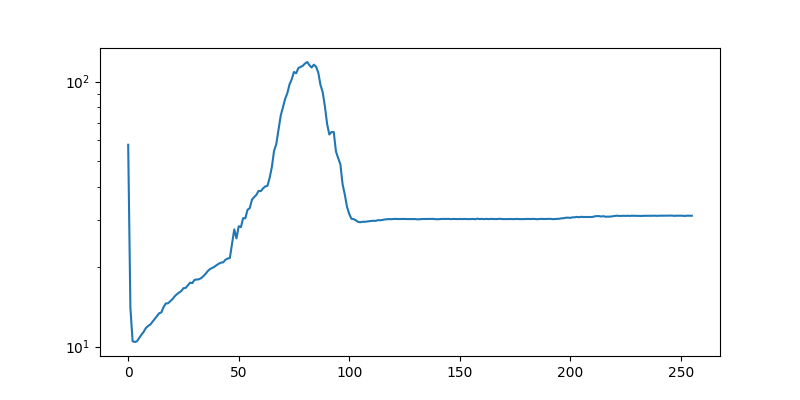

In [544]:
fig, axis = plt.subplots(1,1, figsize = (8,4), squeeze = False)

axis[0,0].semilogy([c.detach().cpu().numpy() for c in convergence])

In [545]:
A_sp = sp.coo_matrix((A[0].cpu().detach().numpy(), (A[1][0].cpu().detach().numpy(), A[1][1].cpu().detach().numpy())), shape = [solverState['fluid']['numParticles'], solverState['fluid']['numParticles']])
M_sp = sp.coo_matrix((M[0].cpu().detach().numpy(), (M[1][0].cpu().detach().numpy(), M[1][1].cpu().detach().numpy())), shape = [solverState['fluid']['numParticles'], solverState['fluid']['numParticles']])
rhs = B.cpu().detach().numpy()


display(A_sp)
display(M_sp)

<16384x16384 sparse matrix of type '<class 'numpy.float32'>'
	with 999424 stored elements in COOrdinate format>

<16384x16384 sparse matrix of type '<class 'numpy.float32'>'
	with 16384 stored elements in COOrdinate format>

In [546]:
B.shape

torch.Size([16384])

In [547]:
bicg = []
bicgstab = []

def callback(x):
    bicg.append(np.linalg.norm(A_sp.dot(x) - rhs))

sol2_nostab = scipy.sparse.linalg.bicg(A_sp, rhs, callback=callback)

def callback(x):
    bicgstab.append(np.linalg.norm(A_sp.dot(x) - rhs))
sol2_nostab = scipy.sparse.linalg.bicgstab(A_sp, rhs, callback=callback)

# bicg_stab_no_prec = []
# bicg_stab_prec = []

# def callback(x):
#     bicg_stab_prec.append(np.linalg.norm(lp2.dot(x) - rhs))

# sol2_nostab = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=callback, M=D)
# def callback(x):
#     bicg_stab_no_prec.append(np.linalg.norm(lp2.dot(x) - rhs))

# sol2_nostab = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=callback)

# gmres = []
# # gmres_no_prec = []

# def callback(r):
#     gmres_prec.append(r)
# sol = scipy.sparse.linalg.gmres(A_sp, rhs, callback=callback, restart=50)

# def callback(r):
#     gmres_no_prec.append(r)
# sol = scipy.sparse.linalg.gmres(lp2, rhs, callback=callback, restart=50)

In [548]:

cg = []
def callback(x):
    cg.append(np.linalg.norm(A_sp.dot(x) - rhs))

sol2_nostab = scipy.sparse.linalg.cg(A_sp, rhs, callback=callback)

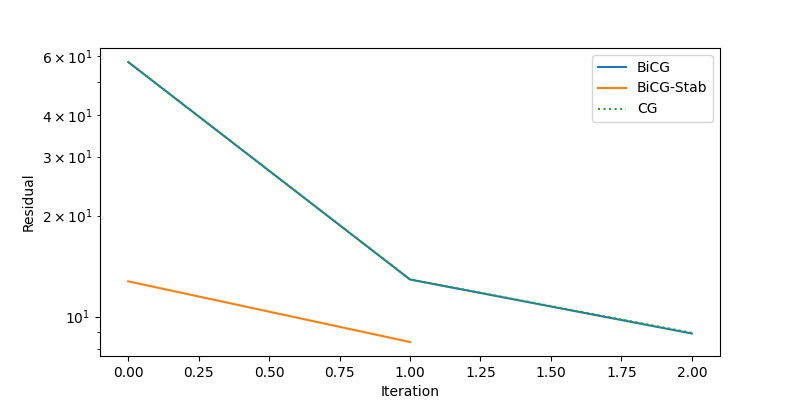

In [549]:
fig, axis = plt.subplots(1,1, figsize = (8,4), squeeze = False)

# axis[0,0].semilogy([c.detach().cpu().numpy() for c in convergence])
axis[0,0].semilogy(bicg, label = 'BiCG')
axis[0,0].semilogy(bicgstab, label = 'BiCG-Stab')
# axis[0,0].semilogy(gmres, label = 'GMRES')
axis[0,0].semilogy(cg, label = 'CG', ls = ':')

# axis[0,0].semilogy([c.detach().cpu().numpy() for c in convergence], label = 'PyTorch')


axis[0,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Residual')

axis[0,0].legend()



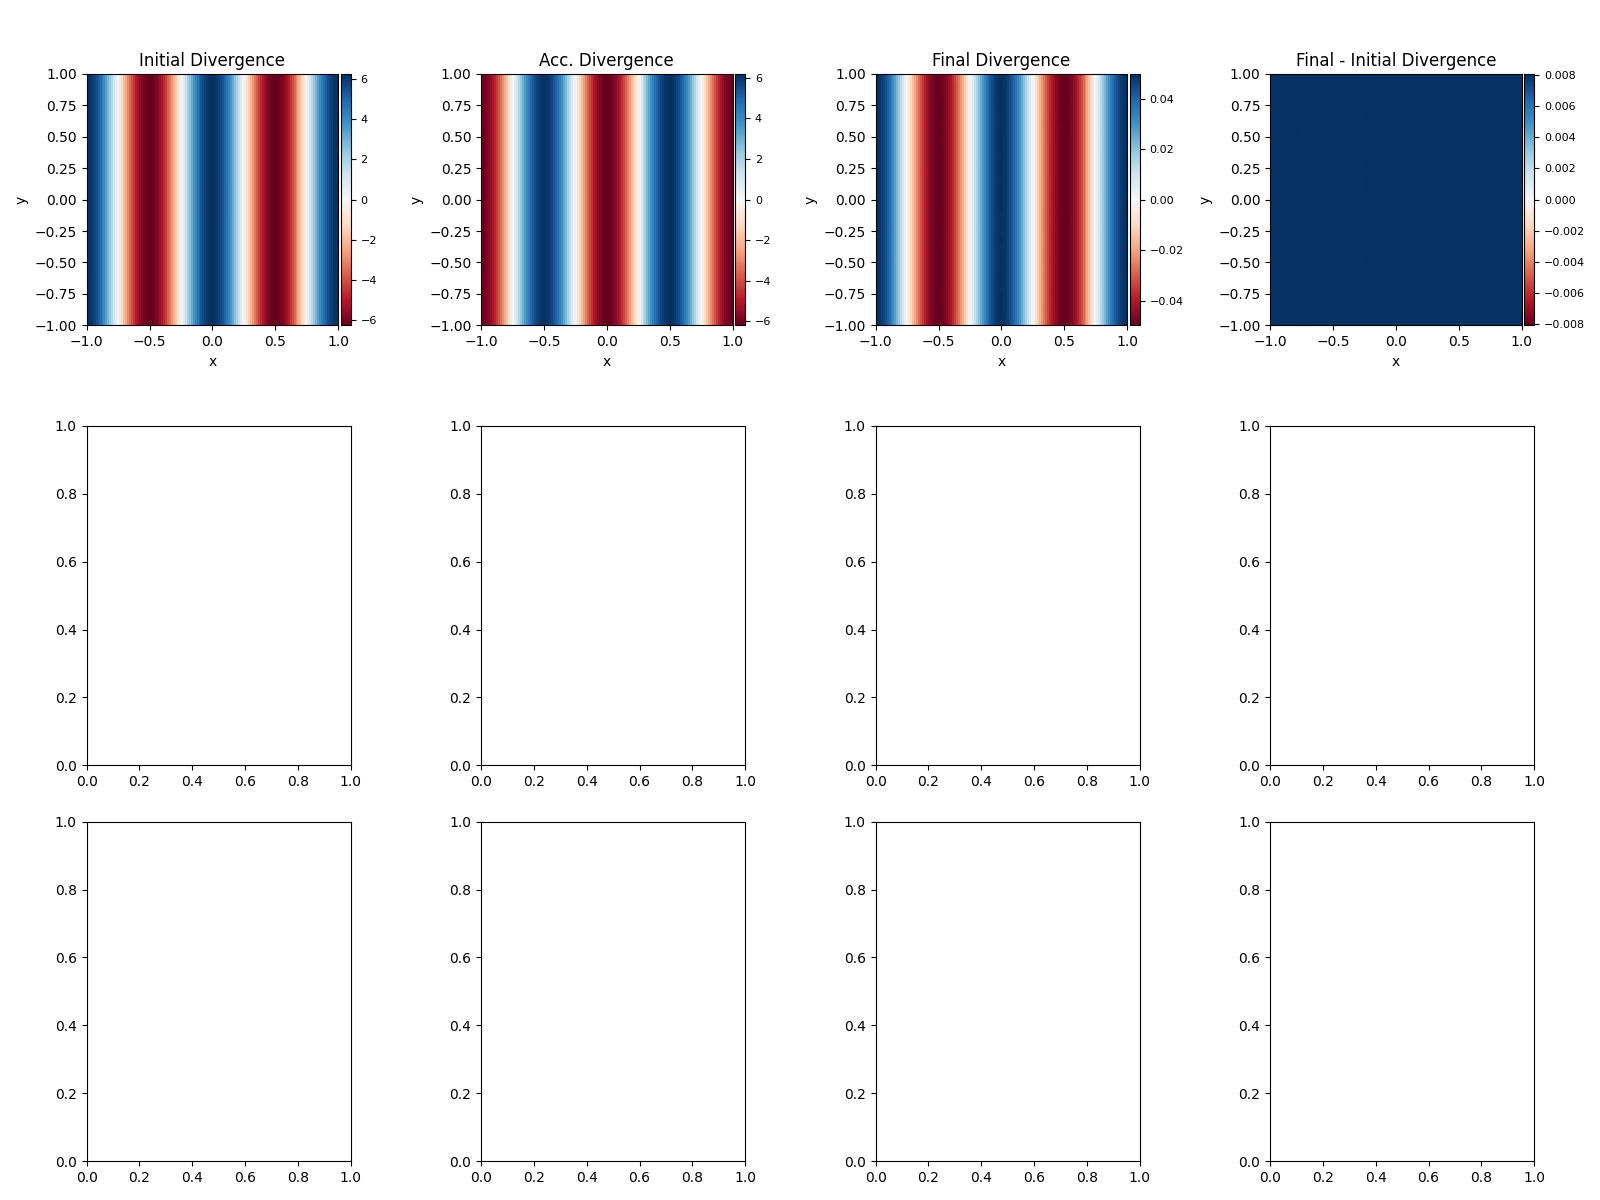

In [550]:
fig, axis = plt.subplots(3,4, figsize = (16,12), squeeze = False)
visualizationState = prepVisualizationState(solverState, config, grid = True)
b = solverState['fluid']['advectionDivergence'] / solverState['dt']
# residualPlot_00 = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
#                                     b, mapping = '.x', s = s, 
#                         scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = f'Iteration {i}', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
# print(f'Iteration {i} mean residual: {residuals[i].mean()}, min: {residuals[i].min()}, max: {residuals[i].max()}')


for i, (ax, r) in enumerate(zip(axis.flatten()[4:], residuals if len(residuals) < 8 else residuals[-8:])):
    residualPlot_00 = visualizeParticleQuantity(fig, ax, config, visualizationState, quantity =
                                      r - b, mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'RdBu', title = f'Iteration {i}', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
    print(f'Iteration {i} mean residual: {(r-b).mean()}, min: {(r - b).min()}, max: {(r - b ).max()}')

residualPlot_00 = visualizeParticleQuantity(fig, axis.flatten()[0], config, visualizationState, quantity =
                                    initDiv, mapping = '.x', s = s, 
                        scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = f'Initial Divergence', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
residualPlot_00 = visualizeParticleQuantity(fig, axis.flatten()[1], config, visualizationState, quantity =
                                    accDiv, mapping = '.x', s = s, 
                        scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = f'Acc. Divergence', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
residualPlot_00 = visualizeParticleQuantity(fig, axis.flatten()[2], config, visualizationState, quantity =
                                    finalDiv, mapping = '.x', s = s, 
                        scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = f'Final Divergence', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
residualPlot_00 = visualizeParticleQuantity(fig, axis.flatten()[3], config, visualizationState, quantity =
                                    finalDiv/initDiv, mapping = '.x', s = s, 
                        scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = f'Final - Initial Divergence', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)


fig.tight_layout()

In [551]:
finalDiv/accDiv

tensor([-0.0080, -0.0080, -0.0080,  ..., -0.0080, -0.0080, -0.0080],
       device='cuda:0')

In [578]:
solverState = copy.deepcopy(initialState)

solverState['fluid']['velocities'][:,0] = torch.sin(solverState['fluid']['positions'][:,1] * 2 * np.pi)
solverState['fluid']['velocities'][:,1] = 0
solverState['fluid']['pressure'] = torch.zeros_like(solverState['fluid']['densities'])


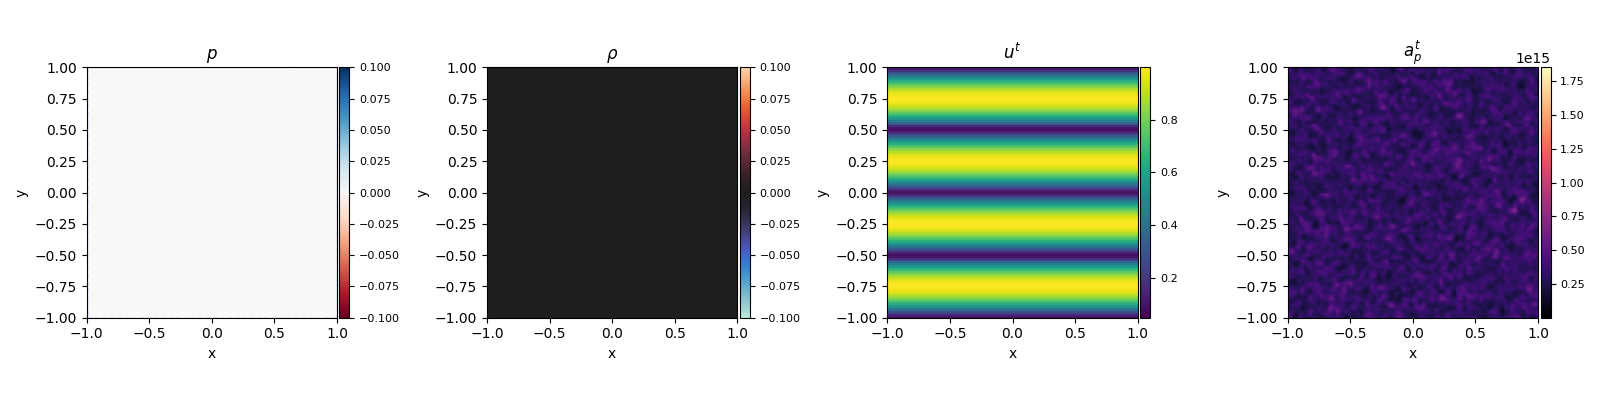

In [579]:
fig, axis = plt.subplots(1,4, figsize = (16,4), squeeze = False)


visualizationState = prepVisualizationState(solverState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25
div = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)


pressurePlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'pressure',
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'RdBu', title = '$p$', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
rhoPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'pressure',
                                      mapping = '.x', s = s, 
                          scaling = 'RdBu', gridVisualization=True, cmap = 'icefire', streamLines = False, operation = None, title = '$\\rho$', plotBoth = False, which = 'fluid', midPoint = 1000)
velPlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      'velocities' ,
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=True, cmap = 'viridis', streamLines = False, operation = None, title = '$u^t$', plotBoth = False, which = 'fluid', midPoint = 0)

accelPlot = visualizeParticleQuantity(fig, axis[0,3], config, visualizationState, quantity = 
                                      a_p ,
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=True, cmap = 'magma', streamLines = False, operation = None, title = '$a_p^t$', plotBoth = False, which = 'fluid', midPoint = 0)


fig.tight_layout()

In [584]:
solverState = copy.deepcopy(initialState)

solverState['fluid']['velocities'][:,0] = torch.sin(solverState['fluid']['positions'][:,1] * 2 * np.pi)
solverState['fluid']['velocities'][:,1] = 0
solverState['fluid']['pressure'] = torch.zeros_like(solverState['fluid']['densities'])


for i in tqdm(range(33)):
    solverState['time'] += perennialState['dt']
    solverState['timestep'] += 1

    searchNeighbors(solverState, config)

    solverState['fluid']['densities'], _ = callModule(solverState, computeDensity, config, 'fluid')
    solverState['fluid']['gravityAccel'] = computeGravity(solverState['fluid'], config)
    solverState['fluid']['velocityDiffusion'], _ = callModule(solverState, computeViscosity, config, 'fluid')
    solverState['fluid']['advection'] = solverState['fluid']['gravityAccel'] + solverState['fluid']['velocityDiffusion']
    solverState['fluid']['advection'][:,0] += torch.sin(2 * np.pi * solverState['fluid']['positions'][:,1]) * solverState['dt']

    
    solverState['fluid']['advectionVelocities'] = solverState['fluid']['velocities'] + solverState['fluid']['advection'] * solverState['dt']
    solverState['fluid']['velocityDivergence'] = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)
    solverState['fluid']['advectionDivergence'] = computeAdvectionDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)


    solverState['fluid']['pressure'], iters, convergence, residuals, A, B, M = solveISPH(solverState['fluid'], solverState['fluid'], config, solverState['fluid']['neighborhood'])

    a_p = sphOperationStates(solverState['fluid'], solverState['fluid'], (solverState['fluid']['pressure'], solverState['fluid']['pressure']), operation = 'gradient', gradientMode='summation', neighborhood= solverState['fluid']['neighborhood']) / solverState['fluid']['densities'].view(-1,1)

    finalVelocities = solverState['fluid']['advectionVelocities'] + a_p* solverState['dt']
    finalDivergence = sphOperationStates(solverState['fluid'], solverState['fluid'], (finalVelocities, finalVelocities), neighborhood=solverState['fluid']['neighborhood'], operation='divergence')


    stateA = solverState['fluid']
    stateB = solverState['fluid']
    neighborhood = stateA['neighborhood']

    initDiv = sphOperationStates(stateA, stateB, (stateA['velocities'], stateB['velocities']), neighborhood=neighborhood, operation='divergence')
    advDiv = sphOperationStates(stateA, stateB, (stateA['advectionVelocities'], stateB['advectionVelocities']), neighborhood=neighborhood, operation='divergence')
    accDiv = sphOperationStates(stateA, stateB, (solverState['dt'] * a_p, solverState['dt'] * a_p), neighborhood=neighborhood, operation='divergence')
    finalDiv = sphOperationStates(stateA, stateB, (finalVelocities, finalVelocities), neighborhood=neighborhood, operation='divergence')


    solverState['fluid']['velocities'] = finalVelocities
    solverState['fluid']['positions'] += finalVelocities * solverState['dt']
    div = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)



    print(f'Iteration: {i}, Divergence: {div.min()} | {div.max()}, Pressure: {solverState["fluid"]["pressure"].min()} | {solverState["fluid"]["pressure"].max()}, densities: {solverState["fluid"]["densities"].min()} | {solverState["fluid"]["densities"].max()}')

    # print(f'Initial Divergence:   {initDiv.min()} | {initDiv.max()} | {initDiv.mean()} | {initDiv}')
    print(f'Advection Divergence: {advDiv.min()} | {advDiv.max()} | {advDiv.mean()} | {advDiv}')
    print(f'Accel Divergence:     {accDiv.min()} | {accDiv.max()} | {accDiv.mean()} | {accDiv}')
    # print(f'Final Divergence:     {finalDiv.min()} | {finalDiv.max()} | {finalDiv.mean()} | {finalDiv}')
    # print(f'Residual:             {(advDiv - accDiv).min()} | {(advDiv - accDiv).max()} | {(advDiv - accDiv).mean()} | {(advDiv - accDiv)}')

    if i % 32 == 0:
        searchNeighbors(solverState, config)
        visualizationState = prepVisualizationState(solverState, config, grid = True)
        # visualizationState = prepVisualizationState(perennialState, config)
        # div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)
        
        # div = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', gradientMode='difference', neighborhood=perennialState['fluid']['neighborhood'])
        updatePlot(pressurePlot, visualizationState, 'pressure')
        updatePlot(rhoPlot, visualizationState, 'densities')
        updatePlot(velPlot, visualizationState, 'velocities')
        updatePlot(accelPlot, visualizationState, a_p)
        
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        # exportPlot(perennialState, config, fig)

  0%|          | 0/33 [00:00<?, ?it/s]

[114066520.0, 109024312.0, 119247696.0, 116723360.0, 109437504.0, 97183304.0, 92740872.0, 87645408.0, 84544344.0, 83882168.0, 82636800.0, 80693552.0, 78817864.0, 74822200.0, 72370736.0, 70823408.0, 69837032.0, 70377720.0, 67868952.0, 66372156.0, 66583624.0, 66561820.0, 67107872.0, 67586440.0, 69864824.0, 74653096.0, 77569064.0, 79297776.0, 80653288.0, 82855992.0, 88031432.0, 87929592.0, 88630416.0, 89619792.0, 90961232.0, 93481392.0, 100016328.0, 105415384.0, 109193776.0, 116953376.0, 128064024.0, 137218384.0, 147446832.0, 154953168.0, 160706592.0, 172744240.0, 183231776.0, 193640928.0, 206070096.0, 214981152.0, 219437776.0, 227832544.0, 230823408.0, 235773296.0, 252330064.0, 264279328.0, 277200448.0, 300058432.0, 324742304.0, 337883456.0, 356945792.0, 388697440.0, 405183200.0, 415653440.0, 439844864.0, 462635680.0, 483505216.0, 528705152.0, 541608704.0, 543632320.0, 563287808.0, 576311616.0, 576886336.0, 585609984.0, 618146560.0, 652337792.0, 665275264.0, 648375040.0, 649300416.0, 672

  0%|          | 0/256 [00:00<?, ?it/s]

[0.1583489626646042, 0.07733796536922455, 0.052843622863292694, 0.04024842008948326, 0.03235901892185211, 0.026884004473686218, 0.02276621013879776, 0.01958506740629673, 0.017193052917718887, 0.01533567439764738, 0.013764981180429459, 0.012241830118000507, 0.010959604755043983, 0.009750910103321075, 0.008801978081464767, 0.008092448115348816, 0.007503774017095566, 0.00699051795527339, 0.006362928077578545, 0.005470598116517067, 0.005397814325988293, 0.004585231188684702, 0.004335539415478706, 0.003939945250749588, 0.026406535878777504, 0.003462046617642045, 0.003168828086927533, 0.003111028578132391, 0.0030905224848538637, 0.002684845821931958, 0.0024267639964818954, 0.0025631713215261698, 0.0024949756916612387, 0.0018495729891583323, 0.0017644591862335801, 0.0011260759783908725, 0.0014113852521404624, 0.0013523445231840014, 0.0010464346269145608, 0.001120393630117178, 0.0010509752901270986, 0.0009478653664700687, 0.0008552554063498974, 0.0008296513697132468, 0.0007834323332644999, 0.0

RuntimeError: shape mismatch: value tensor of shape [16384] cannot be broadcast to indexing result of shape [3903]

In [ ]:
priorState = None
for i in tqdm(range(4096)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    # dx, _ = solveShifting(perennialState, config)
    # numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    # perennialState['fluid']['shiftAmount'] = dx
    # perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]
    # if config['compute']['checkNaN']:
    #     checkNaN(perennialState['fluid']['positions'], 'positions')
    #     checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    perennialState['time'] += perennialState['dt']
    perennialState['timestep'] += 1
    # print(f'Incompressible: Iters: {len(perennialState["fluid"]["convergence_density"])}, residual: {perennialState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(perennialState["fluid"]["convergence_divergence"])}, residual: {perennialState["fluid"]["convergence_divergence"][-1]:.4e}')

    if i % 128 == 0:
        searchNeighbors(perennialState, config)
        visualizationState = prepVisualizationState(perennialState, config)
        div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)
        
        # div = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', gradientMode='difference', neighborhood=perennialState['fluid']['neighborhood'])
        updatePlot(indexPlot, visualizationState, 'velocities')
        updatePlot(quantPlot, visualizationState, 'pressureIncompressible')
        updatePlot(l2Plot, visualizationState, div)
        
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)


        
        E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
        E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
        nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
        Re = u_mag * 2 / nu_total


        fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.4g}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]:.2e}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum():.2f}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$, Incompressible: Iters: {len(perennialState["fluid"]["convergence_density"])}, residual: {perennialState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(perennialState["fluid"]["convergence_divergence"])}, residual: {perennialState["fluid"]["convergence_divergence"][-1]:.4e}\n E_k0: {E_k0:.2f}, E_k: {E_k:.2f}, $\\nu = {nu_total:.2e}$, $Re = {Re:.4g}$')
        # fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.2f}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum()}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$')

        
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)



In [318]:
def computeFinalDivergence(stateA, stateB, neighborhood, simConfig):
    with record_function("[SPH] - Fluid Divergence ($nabla cdot \\bar{v}$)"):
        divergence = sphOperationStates(stateA, stateB, (stateA['finalVelocities'], stateB['finalVelocities']), neighborhood=neighborhood, operation='divergence')
        return divergence
    


print(f'Initial Divergence: {solverState["fluid"]["velocityDivergence"].abs().max()}, mean: {solverState["fluid"]["velocityDivergence"].abs().mean()}')
# div = computeFinalDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)

Initial Divergence: 1.1614457368850708, mean: 0.46628260612487793


In [258]:
from diffSPH.v2.simulationSchemes.dfsph import callModule, computeDensity, computeGravity, computeViscosity, sphOperationStates, scatter_sum
solverState = copy.deepcopy(initialState)

# solverState['fluid']['velocities'][:,0] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10
# solverState['fluid']['velocities'][:,1] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10
searchNeighbors(solverState, config)
solverState['dt'] = 0.01
config['timestep']['dt'] = 0.01

for i in range(32):
    
    solverState['fluid']['densities'], _ = callModule(solverState, computeDensity, config, 'fluid')
    solverState['fluid']['gravityAccel'] = computeGravity(solverState['fluid'], config)
    solverState['fluid']['velocityDiffusion'], _ = callModule(solverState, computeViscosity, config, 'fluid')
    solverState['fluid']['advection'] = solverState['fluid']['gravityAccel'] + solverState['fluid']['velocityDiffusion']
    solverState['fluid']['advectionVelocities'] = solverState['fluid']['velocities'] + solverState['fluid']['advection'] * solverState['dt']
    solverState['fluid']['velocityDivergence'] = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)
    solverState['fluid']['advectionDivergence'] = computeAdvectionDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)


    p, iters, convergence = solveISPH(solverState['fluid'], solverState['fluid'], config, solverState['fluid']['neighborhood'])

    a_p = -sphOperationStates(solverState['fluid'], solverState['fluid'], (p, p), operation = 'gradient', gradientMode='symmetric', neighborhood= solverState['fluid']['neighborhood']) / solverState['fluid']['densities'].view(-1,1)
    finalVelocities = solverState['fluid']['advectionVelocities'] + a_p * solverState['dt']
    finalDivergence = sphOperationStates(solverState['fluid'], solverState['fluid'], (finalVelocities, finalVelocities), neighborhood=solverState['fluid']['neighborhood'], operation='divergence')

    solverState['fluid']['velocities'] = finalVelocities


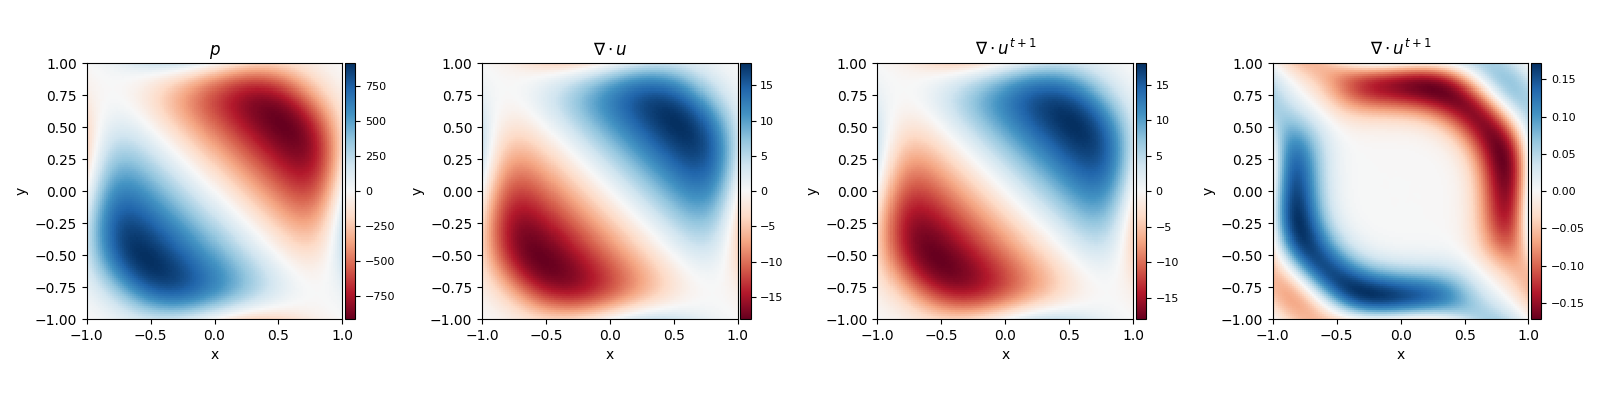

In [238]:
solverState['pressures'] = torch.zeros_like(solverState['fluid']['densities'])

In [239]:
stateA = solverState['fluid']
stateB = solverState['fluid']
neighborhood = stateA['neighborhood']

i,j = neighborhood['indices']
rij = neighborhood['distances']
hij = neighborhood['supports']
xij = neighborhood['vectors']
gradKernels = neighborhood['gradients']
pA = stateA['pressures']
pB = stateB['pressures']

quotient = (rij * hij + 1e-7 * hij)
kernelApproximation = torch.linalg.norm(gradKernels, dim = -1) /  quotient
kernelApproximation = torch.einsum('nd, nd -> n', gradKernels, -xij)/  quotient# * rij * hij

In [206]:
Aij = pA[i] - pB[j]
massTerm = stateA['masses'][j] / (stateA['densities'][i] + stateB['densities'][j])
dimTerm = config['domain']['dim'] * 2 + 2

laplacianTerm = dimTerm * massTerm * kernelApproximation

aii = scatter_sum(laplacianTerm, i, dim = 0, dim_size = stateA['positions'].shape[0])

mask = i == j

A = laplacianTerm
A[mask] = aii

B = solverState['fluid']['advectionDivergence'] / solverState['dt']**3

A = (laplacianTerm, (i,j), stateA['numParticles'])

In [207]:
p, iters, convergence = bicg(A, -B, torch.zeros_like(B), rtol = 1e-10, tol = 1e-8, maxiter = 512)

print(iters, convergence)

p, iters, convergence = bicg(A, -B, p, rtol = 1e-10, tol = 1e-8, maxiter = 512)

Iter 0, Residual: 1567563648.0
Iter 1, Residual: 32864440.0
Iter 2, Residual: 5100007.5
Iter 3, Residual: 977547.5625
Iter 4, Residual: 199048.65625
Iter 5, Residual: 41491.64453125
Iter 6, Residual: 8738.3974609375
Iter 7, Residual: 1852.215576171875
Iter 8, Residual: 394.5318298339844
Iter 9, Residual: 84.29361724853516
Iter 10, Residual: 18.063350677490234
Iter 11, Residual: 3.887315511703491
Iter 12, Residual: 0.8368783593177795
Iter 13, Residual: 0.18033309280872345
14 [tensor(32864442., device='cuda:0'), tensor(5100006., device='cuda:0'), tensor(977554.1875, device='cuda:0'), tensor(199046.0469, device='cuda:0'), tensor(41495.4102, device='cuda:0'), tensor(8747.5312, device='cuda:0'), tensor(1882.0022, device='cuda:0'), tensor(541.1484, device='cuda:0'), tensor(366.3199, device='cuda:0'), tensor(358.9917, device='cuda:0'), tensor(358.6536, device='cuda:0'), tensor(359.9285, device='cuda:0'), tensor(361.6763, device='cuda:0'), tensor(361.5761, device='cuda:0')]
Iter 0, Residual: 3

In [208]:

# p, convergence, iters, residual = BiCGStab_wJacobi(A, B, torch.zeros_like(B), i, j)

# print(f'Iterations: {iters}, Residual: {residual}, {convergence}')
# print(f'p: {p}, min: {p.min()}, max: {p.max()}, mean: {p.mean()}')

In [217]:
a_p = -sphOperationStates(stateA, stateB, (p, p), operation = 'gradient', gradientMode='symmetric', neighborhood= neighborhood) / stateA['densities'].view(-1,1)
finalVelocities = stateA['advectionVelocities'] + a_p * solverState['dt']
finalDivergence = sphOperationStates(stateA, stateB, (finalVelocities, finalVelocities), neighborhood=neighborhood, operation='divergence')



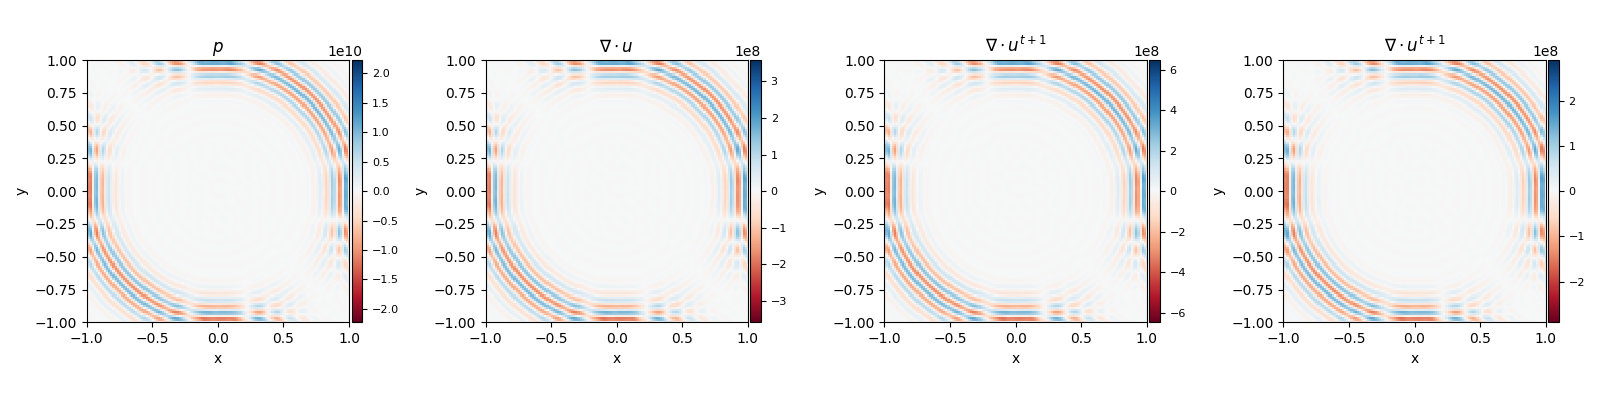

In [240]:
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
from diffSPH.v2.plotting import exportPlot, postProcessPlot
fig, axis = plt.subplots(1,4, figsize = (16,4), squeeze = False)

visualizationState = prepVisualizationState(solverState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

xVelPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      p,
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = '$p$', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
yVelPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'velocityDivergence',
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot u$', plotBoth = False, which = 'fluid', midPoint = 0)

velPlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      finalDivergence,
                                      mapping = 'L2', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot u^{t+1}$', plotBoth = False, which = 'fluid', midPoint = 0)
velPlot = visualizeParticleQuantity(fig, axis[0,3], config, visualizationState, quantity = 
                                      finalDivergence - solverState['fluid']['velocityDivergence'],
                                      mapping = 'L2', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot u^{t+1}$', plotBoth = False, which = 'fluid', midPoint = 0)



fig.tight_layout()

# simulationState['fluid']['actualArea'] = simulationState['fluid']['masses'] / simulationState['fluid']['densities']
# 



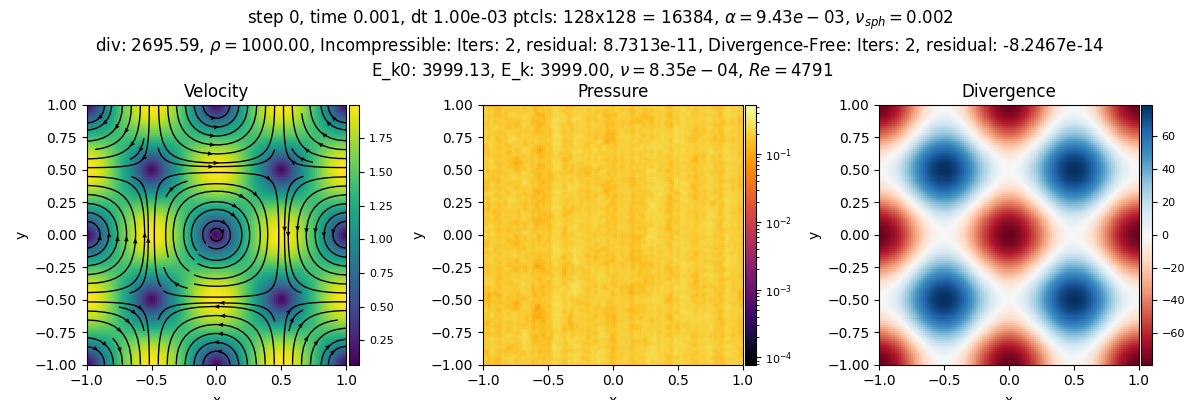

In [8]:
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
from diffSPH.v2.plotting import exportPlot, postProcessPlot
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'velocities',
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=True, cmap = 'viridis', title = 'Velocity', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = True)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'pressureIncompressible',
                                      mapping = '.y', s = s, 
                          scaling = 'log', gridVisualization=True, cmap = 'inferno', streamLines = False, operation = None, title = 'Pressure', plotBoth = False, which = 'fluid', midPoint = 1000)

l2Plot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      div,
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = 'Divergence', plotBoth = False, which = 'fluid', midPoint = 0)

E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
Re = u_mag * 2 / nu_total

fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.4g}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]:.2e}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum():.2f}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$, Incompressible: Iters: {len(priorState["fluid"]["convergence_density"])}, residual: {priorState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(priorState["fluid"]["convergence_divergence"])}, residual: {priorState["fluid"]["convergence_divergence"][-1]:.4e}\n E_k0: {E_k0:.2f}, E_k: {E_k:.2f}, $\\nu = {nu_total:.2e}$, $Re = {Re:.4g}$')

fig.tight_layout()

# simulationState['fluid']['actualArea'] = simulationState['fluid']['masses'] / simulationState['fluid']['densities']
# 



In [13]:
priorState = None
for i in tqdm(range(4096)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    # dx, _ = solveShifting(perennialState, config)
    # numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    # perennialState['fluid']['shiftAmount'] = dx
    # perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]
    # if config['compute']['checkNaN']:
    #     checkNaN(perennialState['fluid']['positions'], 'positions')
    #     checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    perennialState['time'] += perennialState['dt']
    perennialState['timestep'] += 1
    # print(f'Incompressible: Iters: {len(perennialState["fluid"]["convergence_density"])}, residual: {perennialState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(perennialState["fluid"]["convergence_divergence"])}, residual: {perennialState["fluid"]["convergence_divergence"][-1]:.4e}')

    if i % 128 == 0:
        searchNeighbors(perennialState, config)
        visualizationState = prepVisualizationState(perennialState, config)
        div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)
        
        # div = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', gradientMode='difference', neighborhood=perennialState['fluid']['neighborhood'])
        updatePlot(indexPlot, visualizationState, 'velocities')
        updatePlot(quantPlot, visualizationState, 'pressureIncompressible')
        updatePlot(l2Plot, visualizationState, div)
        
        
        E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
        E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
        nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
        Re = u_mag * 2 / nu_total


        fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.4g}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]:.2e}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum():.2f}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$, Incompressible: Iters: {len(perennialState["fluid"]["convergence_density"])}, residual: {perennialState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(perennialState["fluid"]["convergence_divergence"])}, residual: {perennialState["fluid"]["convergence_divergence"][-1]:.4e}\n E_k0: {E_k0:.2f}, E_k: {E_k:.2f}, $\\nu = {nu_total:.2e}$, $Re = {Re:.4g}$')
        # fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.2f}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum()}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$')

        
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)



  0%|          | 0/4096 [00:00<?, ?it/s]

In [14]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

CompletedProcess(args=['ffmpeg', '-loglevel', 'warning', '-hide_banner', '-y', '-i', 'output/2024_07_04-11_20_46/output.mp4', '-i', 'output/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_07_04-11_20_46.gif'], returncode=0)